In [1]:
import os
import json
from timeit import default_timer as timer
import numpy as np
import scipy.linalg as la
import theano as th
import theano.tensor as tt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from dgm import model_wrappers, pose, utils
import dgm.pose_visualisation as vis
import bvh.reader, bvh.helpers
import hmc.constrained, hmc.unconstrained
%matplotlib inline

## Set up experiment directories

In [2]:
base_dir = os.path.dirname(os.getcwd())
exp_dir = os.path.join(base_dir, 'results', 'pose-inference-binocular')
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
joint_angle_model_dir = os.path.join(base_dir, 'models', 'joint-angles-sin-cos-vae-decoder')
bone_length_model_dir = os.path.join(base_dir, 'models', 'bone-length-log-normal')

In [3]:
logger = utils.setup_logger(exp_dir)

## Define generator constants

In [4]:
consts = {
    'seed': 1234,
    'n_joint': 19,
    'n_joint_angle': 47,
    'n_joint_angle_latent': 30,
    'n_bone_length_input': 13,
    'n_camera_input': 3,
    'output_noise_std': 0.001,
    'cam_foc': np.exp(2.),
    'cam_pos_x_mean': 0.,
    'cam_pos_y_mean': 0.,
    'cam_pos_x_std': 0.1,
    'cam_pos_y_std': 0.1,
    'log_cam_pos_z_mean': 1.5,
    'log_cam_pos_z_std': 0.5,
    'cam_ang': np.array([np.pi, 0., 0.]),
    'cam_pos_offset': np.array([0.5, 0., 0.]),
    'cam_ang_offset': np.array([0.0, 0., 0.])
}
consts['n_joint_angle_input'] = (
    consts['n_joint_angle_latent'] + 
    consts['n_joint_angle'] * 2)

In [5]:
bvh_reader = bvh.reader.BvhReader(
    os.path.join(joint_angle_model_dir, 'skeleton.bvh'))
bvh_reader.read()
bvh.helpers.process_skeleton(bvh_reader.root)
consts['skeleton'] = bvh_reader.root
with open(os.path.join(joint_angle_model_dir, 'fixed_angles.json'), 'r') as f:
    consts['fixed_joint_angles'] = json.load(f)

In [6]:
with np.load(os.path.join(joint_angle_model_dir, 'params.npz')) as f:
    num_layers = 7
    consts['joint_angles_vae_decoder_layers'] = [
        {
            'weights': tt.constant(f['W_{0}'.format(l)], 'W_{0}'.format(l), 2, th.config.floatX),
            'biases': tt.constant(f['b_{0}'.format(l)], 'b_{0}'.format(l), 1, th.config.floatX),
            'nonlinearity':  tt.tanh if l != num_layers - 1 else lambda x: x
        }
        for l in range(num_layers)
    ]

In [7]:
consts['joints_to_skip'] = [
    'hips',
    'leftshoulder',
    'rightshoulder', 
    'lefthandthumb1', 
    'righthandthumb1', 
    'lefthandthumb1endsite', 
    'righthandthumb1endsite',
    'lefttoebaseendsite',
    'righttoebaseendsite'
]

In [8]:
lengths_model_params = np.load(os.path.join(bone_length_model_dir, 'params.npz'))
consts['log_lengths_covar'] = th.shared(lengths_model_params['covar'], 'log_lengths_covar')
consts['log_lengths_covar_chol'] = th.shared(la.cholesky(lengths_model_params['covar'], False))
consts['log_lengths_mean'] = th.shared(lengths_model_params['mean'], 'log_lengths_mean')

In [9]:
with open(os.path.join(bone_length_model_dir, 'lengths_order.json'), 'r') as f:
    lengths_order = json.load(f)
consts['bone_lengths_map'] = {
    node_name: lengths_order[length_name] 
    for node_name, length_name 
    in bvh.helpers.bone_lengths_map.items()
    if node_name not in ['lefthandthumb1endsite', 'righthandthumb1endsite']
}

In [10]:
rng = np.random.RandomState(consts['seed'])

## Set up model

In [11]:
n_noise = consts['n_joint'] * 4
n_in_dim = (
    consts['n_camera_input'] + 
    consts['n_bone_length_input'] + 
    consts['n_joint_angle_input'] + 
    4 * consts['n_joint']
)

In [12]:
model = model_wrappers.MinimalDifferentiableGenerativeModel(
    generator=pose.noisy_binocular_2d_proj_generator,
    constants=consts,
    calc_gram_chol=lambda jac: la.cho_factor(
        jac[:, :-n_noise].dot(jac[:, :-n_noise].T) + jac[:, -n_noise:]**2)
)

2017-03-15 21:51:43 dgm.model_wrappers:INFO Compiling generator function...
2017-03-15 21:51:54 dgm.model_wrappers:INFO ... finished in 11.1s
2017-03-15 21:51:54 dgm.model_wrappers:INFO Compiling generator Jacobian...
2017-03-15 21:52:26 dgm.model_wrappers:INFO ... finished in 31.7s
2017-03-15 21:52:26 dgm.model_wrappers:INFO Compiling energy gradient...
2017-03-15 21:54:52 dgm.model_wrappers:INFO ... finished in 146.1s
2017-03-15 21:54:52 dgm.model_wrappers:INFO Compiling base energy function...
2017-03-15 21:54:52 dgm.model_wrappers:INFO ... finished in 0.0s


In [13]:
u = tt.matrix('u')
y_bin = pose.noisy_binocular_2d_proj_generator(u, consts)
y_3d = pose.joint_3d_pos_generator(u, consts)
generator_binocular = th.function([u], y_bin)
generator_3d = th.function([u], y_3d)

## Observed data

In [14]:
n_data = 3
rng.seed(consts['seed'])
u_data = rng.normal(size=(n_data, n_in_dim))
y_data = generator_binocular(u_data)
y_data_3d = generator_3d(u_data)
np.savez(os.path.join(exp_dir, 'observed-data.npz'), 
         u_data=u_data, y_data=y_data, y_data_3d=y_data_3d)

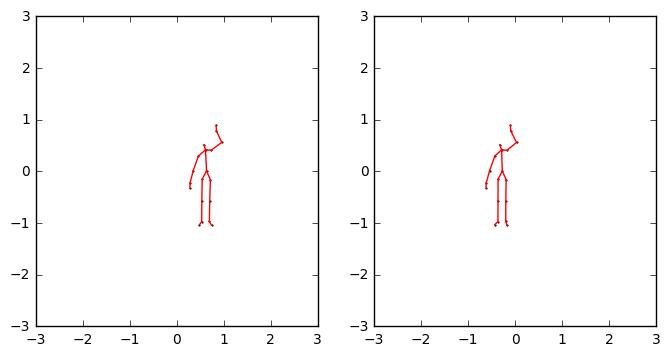

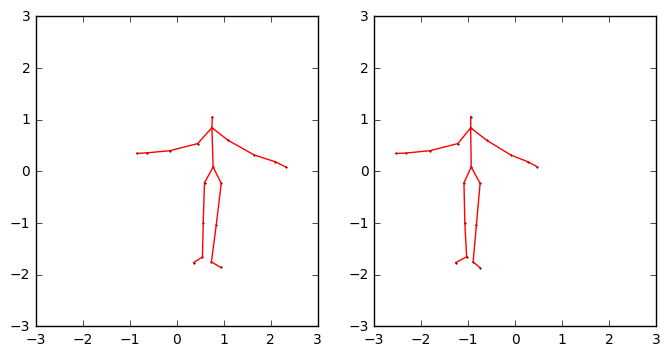

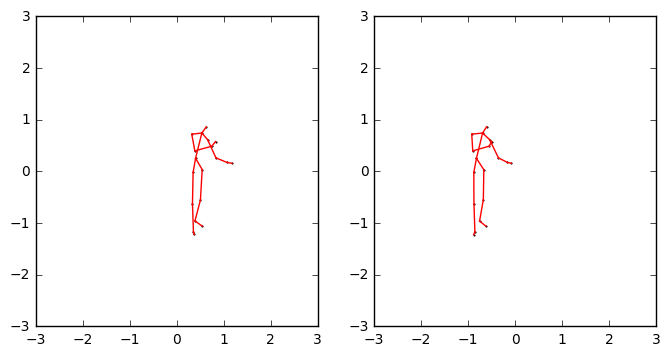

In [15]:
for bin_proj in y_data:
    joints_1, joints_2 = bin_proj.reshape((2, 2, -1))
    fig, ax1, ax2 = vis.plot_binocular_projections(
        joints_1.T, joints_2.T, fig_size=(8, 4))
    ax1.axis([-3, 3, -3, 3])
    ax2.axis([-3, 3, -3, 3])

## Constrained HMC

In [16]:
constr_sampler = hmc.constrained.LfGbabConstrainedIsotropicHmcSampler(
    model.energy_func,
    model.constr_func,
    model.energy_grad,
    model.constr_jacob,
    rng,
    tol=1e-8,
    max_iters=100,
    n_inner_update=20,
    check_reverse=True
)
n_step_per_sample = (10, 15)
n_sample = 90
rng.seed(consts['seed'])
n_run = 10
chmc_times = np.empty(n_run) * np.nan
chmc_dists = np.empty((n_run, n_sample)) * np.nan

2017-03-15 21:55:11 root:INFO Starting dt=0.1 data 1 run 1...
2017-03-15 22:04:19 root:INFO ...completed, accepted: 0.988888888889, run time: 548.6s


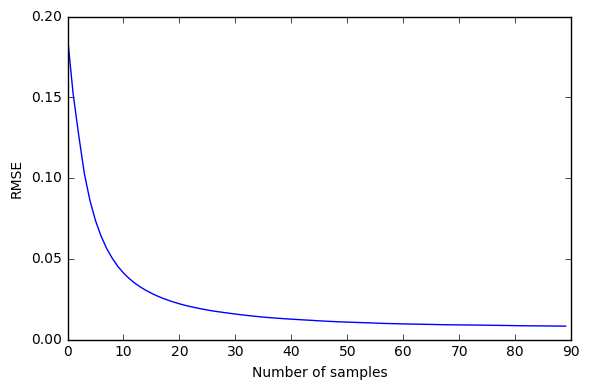

2017-03-15 22:04:20 root:INFO Starting dt=0.1 data 1 run 2...
2017-03-15 22:11:24 hmc.constrained:INFO Quasi-Newton iteration diverged.
2017-03-15 22:11:24 hmc.constrained:INFO Quasi-Newton iteration did not converge within max_iters.
Last max error: nan
Falling back to scipy.optimize.root(hybrj).
2017-03-15 22:11:24 hmc.base:INFO Error occured when simulating dynamic. Rejecting.
Solver (scipy.optimize.root(hybrj)) did not converge.
Maximum number of iterations: 100
Maximum error for convergence: 1e-08
Last maximum error: 4.19696721821e-10
2017-03-15 22:13:36 root:INFO ...completed, accepted: 0.955555555556, run time: 556.6s


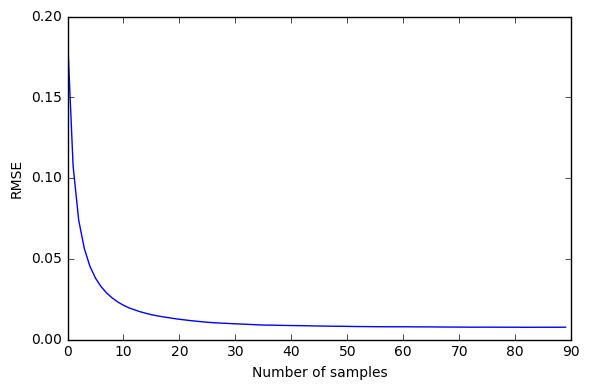

2017-03-15 22:13:37 root:INFO Starting dt=0.1 data 1 run 3...
2017-03-15 22:22:51 root:INFO ...completed, accepted: 0.988888888889, run time: 554.5s


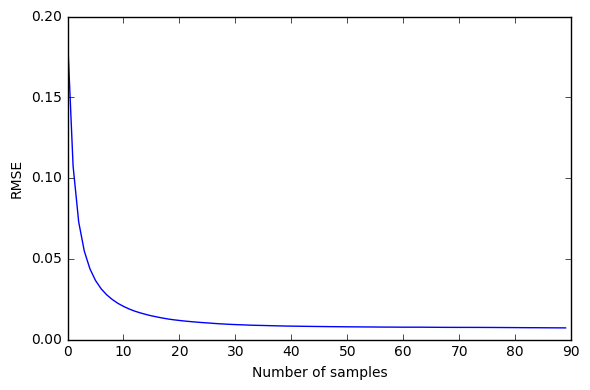

2017-03-15 22:22:52 root:INFO Starting dt=0.1 data 1 run 4...
2017-03-15 22:25:18 hmc.constrained:INFO Quasi-Newton iteration diverged.
2017-03-15 22:25:18 hmc.constrained:INFO Quasi-Newton iteration did not converge within max_iters.
Last max error: nan
Falling back to scipy.optimize.root(hybrj).
2017-03-15 22:25:18 hmc.base:INFO Error occured when simulating dynamic. Rejecting.
Solver (scipy.optimize.root(hybrj)) did not converge.
Maximum number of iterations: 100
Maximum error for convergence: 1e-08
Last maximum error: 1.63508718238e-05
2017-03-15 22:29:32 hmc.constrained:INFO Quasi-Newton iteration did not converge within max_iters.
Last max error: 0.00715309762007
Falling back to scipy.optimize.root(hybrj).
2017-03-15 22:29:33 hmc.base:INFO Error occured when simulating dynamic. Rejecting.
Non-reversible geodesic step.
Maximum absolute distance between positions: 2.82208793871e-05
Estimated maximum absolute distance in constraint space: 1.49994618974e-05
Distance tolerance: 1e-08


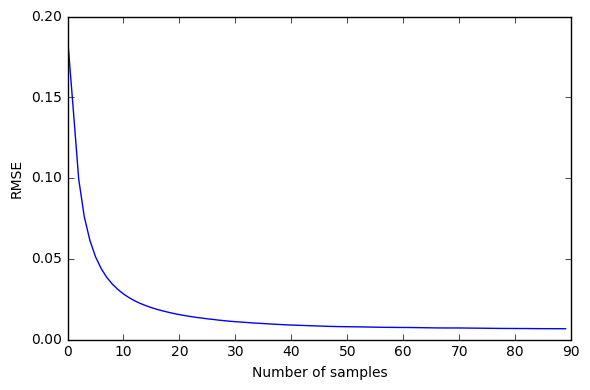

2017-03-15 22:31:43 root:INFO Starting dt=0.1 data 1 run 5...
2017-03-15 22:32:11 hmc.constrained:INFO Quasi-Newton iteration did not converge within max_iters.
Last max error: 0.0179058973614
Falling back to scipy.optimize.root(hybrj).
2017-03-15 22:32:11 hmc.base:INFO Error occured when simulating dynamic. Rejecting.
Non-reversible geodesic step.
Maximum absolute distance between positions: 1.05697336483e-05
Estimated maximum absolute distance in constraint space: 9.61764790231e-06
Distance tolerance: 1e-08
2017-03-15 22:33:08 hmc.constrained:INFO Quasi-Newton iteration did not converge within max_iters.
Last max error: 1.31961205074e-07
Falling back to scipy.optimize.root(hybrj).
2017-03-15 22:33:08 hmc.constrained:INFO Quasi-Newton iteration diverged.
2017-03-15 22:33:08 hmc.constrained:INFO Quasi-Newton iteration did not converge within max_iters.
Last max error: nan
Falling back to scipy.optimize.root(hybrj).
2017-03-15 22:33:08 hmc.base:INFO Error occured when simulating dynamic

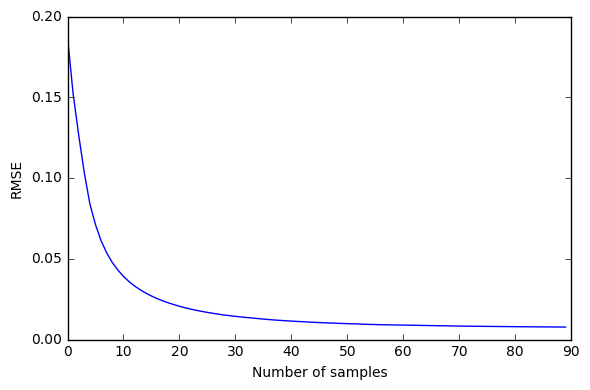

2017-03-15 22:41:05 root:INFO Starting dt=0.1 data 1 run 6...
2017-03-15 22:50:06 root:INFO ...completed, accepted: 1.0, run time: 541.1s


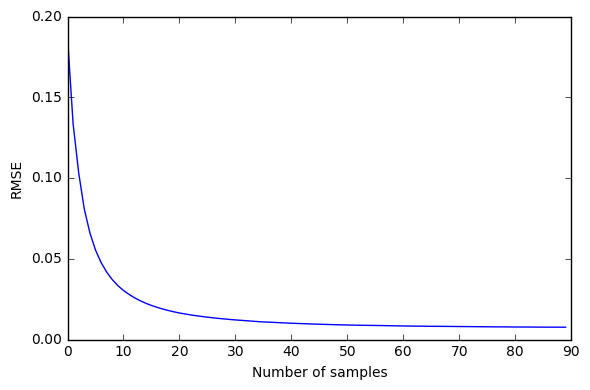

2017-03-15 22:50:06 root:INFO Starting dt=0.1 data 1 run 7...
2017-03-15 22:58:51 root:INFO ...completed, accepted: 1.0, run time: 525.4s


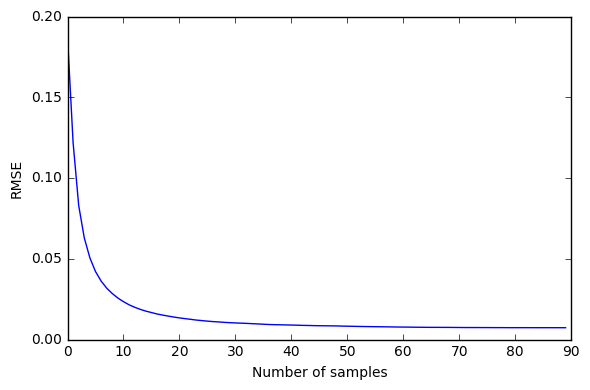

2017-03-15 22:58:52 root:INFO Starting dt=0.1 data 1 run 8...
2017-03-15 23:07:44 root:INFO ...completed, accepted: 1.0, run time: 532.0s


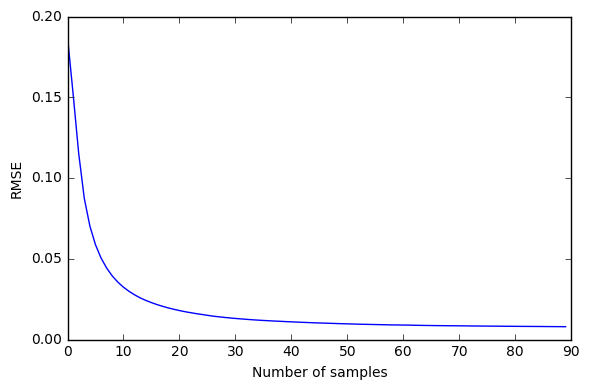

2017-03-15 23:07:44 root:INFO Starting dt=0.1 data 1 run 9...
2017-03-15 23:16:30 root:INFO ...completed, accepted: 1.0, run time: 526.0s


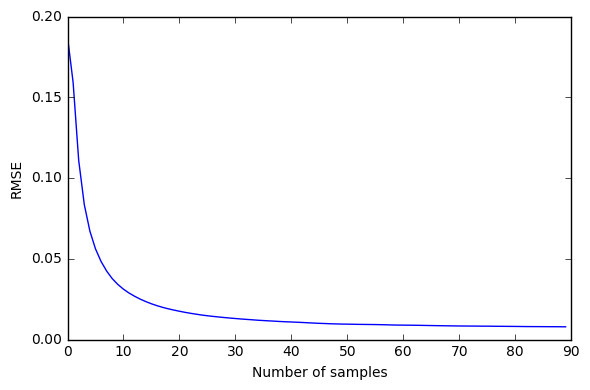

2017-03-15 23:16:30 root:INFO Starting dt=0.1 data 1 run 10...
2017-03-15 23:25:47 root:INFO ...completed, accepted: 0.988888888889, run time: 556.4s


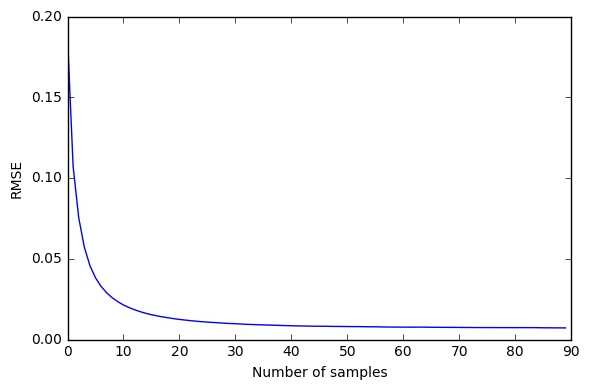

2017-03-15 23:25:47 root:INFO Starting dt=0.1 data 2 run 1...
2017-03-15 23:27:47 hmc.constrained:INFO Quasi-Newton iteration diverged.
2017-03-15 23:27:47 hmc.constrained:INFO Quasi-Newton iteration did not converge within max_iters.
Last max error: nan
Falling back to scipy.optimize.root(hybrj).
2017-03-15 23:27:47 hmc.constrained:INFO Quasi-Newton iteration diverged.
2017-03-15 23:27:47 hmc.constrained:INFO Quasi-Newton iteration did not converge within max_iters.
Last max error: nan
Falling back to scipy.optimize.root(hybrj).
2017-03-15 23:27:47 hmc.constrained:INFO Quasi-Newton iteration diverged.
2017-03-15 23:27:47 hmc.constrained:INFO Quasi-Newton iteration did not converge within max_iters.
Last max error: nan
Falling back to scipy.optimize.root(hybrj).
2017-03-15 23:27:47 hmc.base:INFO Error occured when simulating dynamic. Rejecting.
Solver (scipy.optimize.root(hybrj)) did not converge.
Maximum number of iterations: 100
Maximum error for convergence: 1e-08
Last maximum error

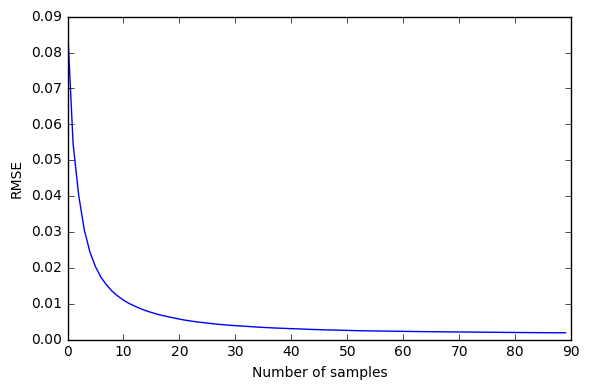

2017-03-15 23:34:13 root:INFO Starting dt=0.1 data 2 run 2...
2017-03-15 23:43:00 root:INFO ...completed, accepted: 1.0, run time: 527.8s


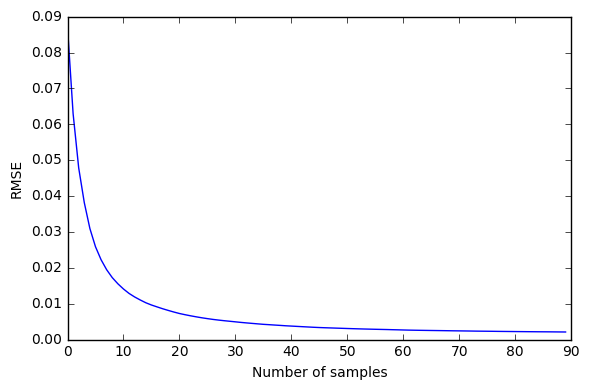

2017-03-15 23:43:01 root:INFO Starting dt=0.1 data 2 run 3...
2017-03-15 23:48:39 hmc.constrained:INFO Quasi-Newton iteration did not converge within max_iters.
Last max error: 0.00726703538366
Falling back to scipy.optimize.root(hybrj).
2017-03-15 23:48:39 hmc.base:INFO Error occured when simulating dynamic. Rejecting.
Solver (scipy.optimize.root(hybrj)) did not converge.
Maximum number of iterations: 100
Maximum error for convergence: 1e-08
Last maximum error: 2.14236965501e-07
2017-03-15 23:50:34 hmc.constrained:INFO Quasi-Newton iteration did not converge within max_iters.
Last max error: 0.00212952736152
Falling back to scipy.optimize.root(hybrj).
2017-03-15 23:50:34 hmc.constrained:INFO Quasi-Newton iteration diverged.
2017-03-15 23:50:34 hmc.constrained:INFO Quasi-Newton iteration did not converge within max_iters.
Last max error: nan
Falling back to scipy.optimize.root(hybrj).
2017-03-15 23:50:34 hmc.constrained:INFO Quasi-Newton iteration did not converge within max_iters.
Las

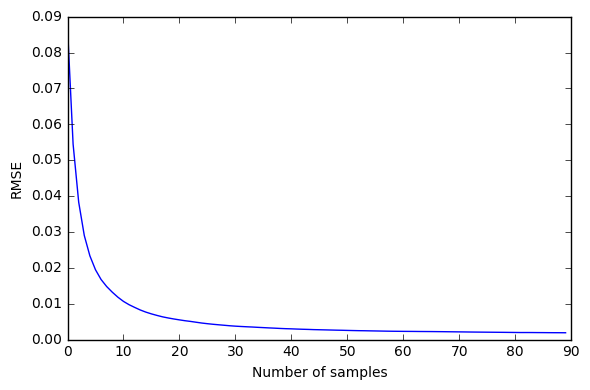

2017-03-15 23:52:10 root:INFO Starting dt=0.1 data 2 run 4...
2017-03-15 23:54:35 hmc.constrained:INFO Quasi-Newton iteration diverged.
2017-03-15 23:54:35 hmc.constrained:INFO Quasi-Newton iteration did not converge within max_iters.
Last max error: nan
Falling back to scipy.optimize.root(hybrj).
2017-03-16 00:00:58 root:INFO ...completed, accepted: 0.977777777778, run time: 528.2s


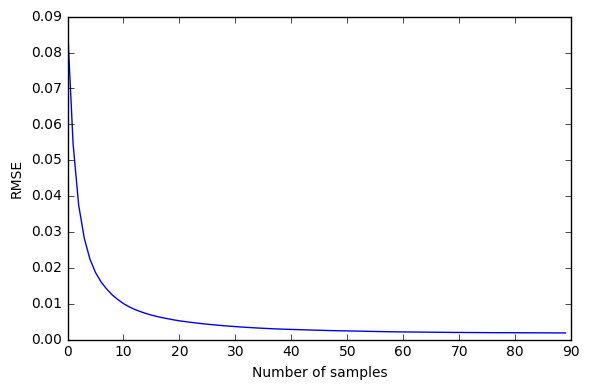

2017-03-16 00:00:58 root:INFO Starting dt=0.1 data 2 run 5...
2017-03-16 00:05:36 hmc.constrained:INFO Quasi-Newton iteration diverged.
2017-03-16 00:05:36 hmc.constrained:INFO Quasi-Newton iteration did not converge within max_iters.
Last max error: nan
Falling back to scipy.optimize.root(hybrj).
2017-03-16 00:05:36 hmc.constrained:INFO Quasi-Newton iteration diverged.
2017-03-16 00:05:36 hmc.constrained:INFO Quasi-Newton iteration did not converge within max_iters.
Last max error: nan
Falling back to scipy.optimize.root(hybrj).
2017-03-16 00:05:36 hmc.constrained:INFO Quasi-Newton iteration did not converge within max_iters.
Last max error: 0.00341675343867
Falling back to scipy.optimize.root(hybrj).
2017-03-16 00:05:37 hmc.base:INFO Error occured when simulating dynamic. Rejecting.
Solver (scipy.optimize.root(hybrj)) did not converge.
Maximum number of iterations: 100
Maximum error for convergence: 1e-08
Last maximum error: 0.00110239290194
2017-03-16 00:09:34 root:INFO ...completed

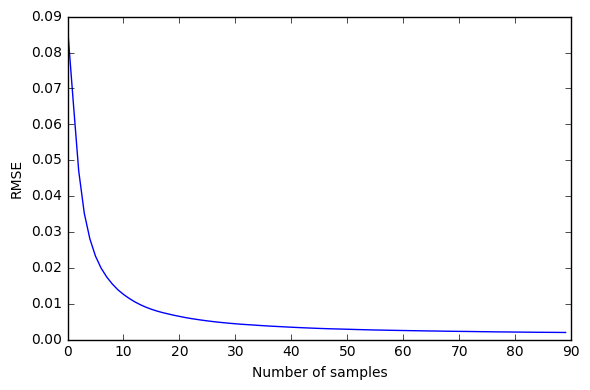

2017-03-16 00:09:34 root:INFO Starting dt=0.1 data 2 run 6...
2017-03-16 00:15:56 hmc.constrained:INFO Quasi-Newton iteration diverged.
2017-03-16 00:15:56 hmc.constrained:INFO Quasi-Newton iteration did not converge within max_iters.
Last max error: nan
Falling back to scipy.optimize.root(hybrj).
2017-03-16 00:15:56 hmc.base:INFO Error occured when simulating dynamic. Rejecting.
Non-reversible geodesic step.
Maximum absolute distance between positions: 7.4999362587e-05
Estimated maximum absolute distance in constraint space: 9.61103268772e-05
Distance tolerance: 1e-08
2017-03-16 00:18:36 root:INFO ...completed, accepted: 0.988888888889, run time: 542.1s


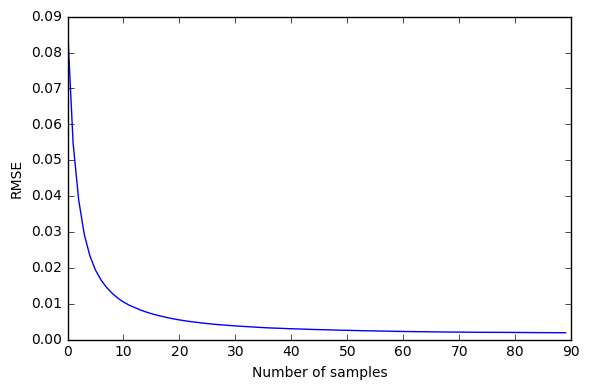

2017-03-16 00:18:37 root:INFO Starting dt=0.1 data 2 run 7...
2017-03-16 00:27:40 root:INFO ...completed, accepted: 0.977777777778, run time: 543.3s


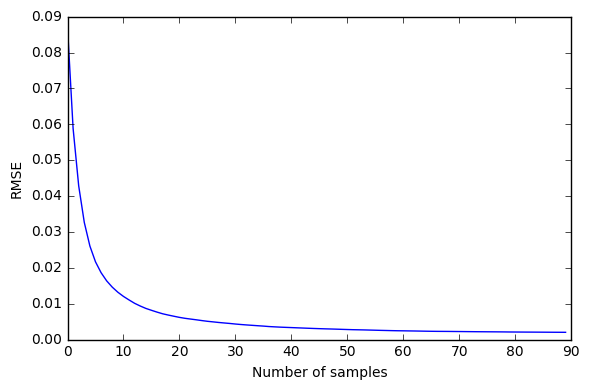

2017-03-16 00:27:40 root:INFO Starting dt=0.1 data 2 run 8...
2017-03-16 00:34:31 hmc.constrained:INFO Quasi-Newton iteration diverged.
2017-03-16 00:34:31 hmc.constrained:INFO Quasi-Newton iteration did not converge within max_iters.
Last max error: nan
Falling back to scipy.optimize.root(hybrj).
2017-03-16 00:34:31 hmc.base:INFO Error occured when simulating dynamic. Rejecting.
Solver (scipy.optimize.root(hybrj)) did not converge.
Maximum number of iterations: 100
Maximum error for convergence: 1e-08
Last maximum error: 3.93220084938e-07
2017-03-16 00:36:18 root:INFO ...completed, accepted: 0.955555555556, run time: 517.7s


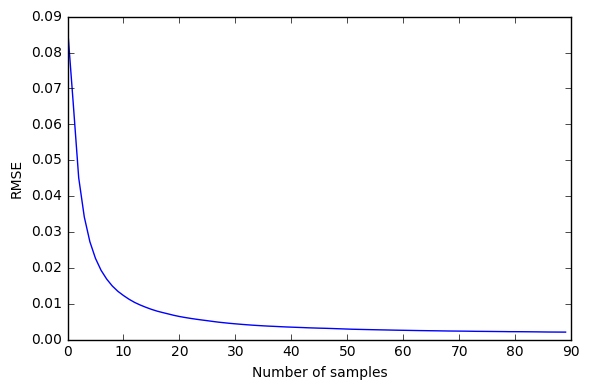

2017-03-16 00:36:18 root:INFO Starting dt=0.1 data 2 run 9...
2017-03-16 00:44:53 root:INFO ...completed, accepted: 1.0, run time: 514.4s


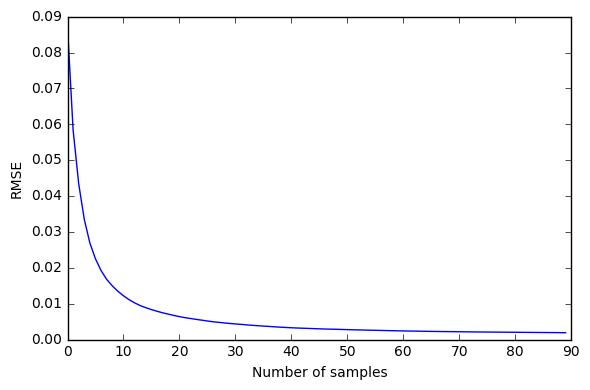

2017-03-16 00:44:53 root:INFO Starting dt=0.1 data 2 run 10...
2017-03-16 00:52:08 hmc.constrained:INFO Quasi-Newton iteration diverged.
2017-03-16 00:52:08 hmc.constrained:INFO Quasi-Newton iteration did not converge within max_iters.
Last max error: nan
Falling back to scipy.optimize.root(hybrj).
2017-03-16 00:52:08 hmc.base:INFO Error occured when simulating dynamic. Rejecting.
Solver (scipy.optimize.root(hybrj)) did not converge.
Maximum number of iterations: 100
Maximum error for convergence: 1e-08
Last maximum error: 2.97861686427e-08
2017-03-16 00:53:48 root:INFO ...completed, accepted: 0.955555555556, run time: 535.0s


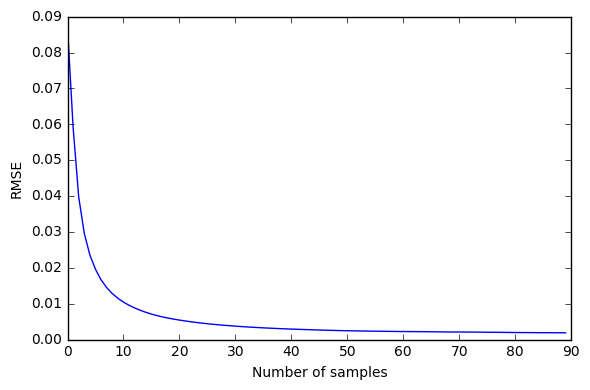

2017-03-16 00:53:48 root:INFO Starting dt=0.1 data 3 run 1...
2017-03-16 00:57:34 hmc.constrained:INFO Quasi-Newton iteration diverged.
2017-03-16 00:57:34 hmc.constrained:INFO Quasi-Newton iteration did not converge within max_iters.
Last max error: nan
Falling back to scipy.optimize.root(hybrj).
2017-03-16 00:57:34 hmc.base:INFO Error occured when simulating dynamic. Rejecting.
Solver (scipy.optimize.root(hybrj)) did not converge.
Maximum number of iterations: 100
Maximum error for convergence: 1e-08
Last maximum error: 1.18025992002e-06
2017-03-16 01:03:02 root:INFO ...completed, accepted: 0.966666666667, run time: 554.3s


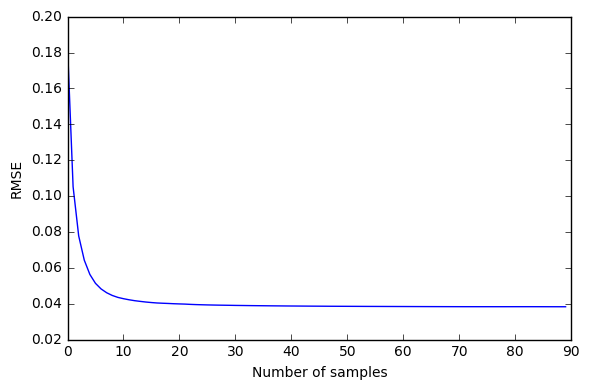

2017-03-16 01:03:03 root:INFO Starting dt=0.1 data 3 run 2...
2017-03-16 01:12:30 root:INFO ...completed, accepted: 0.977777777778, run time: 567.6s


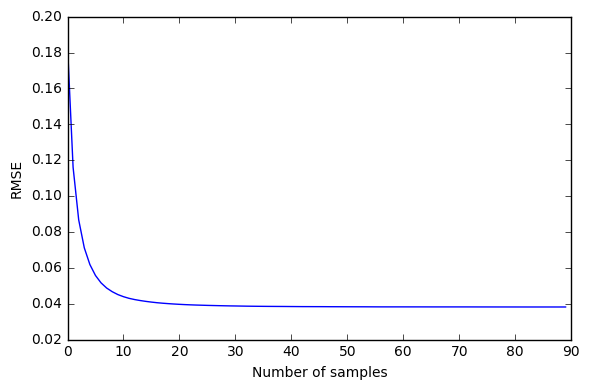

2017-03-16 01:12:31 root:INFO Starting dt=0.1 data 3 run 3...
2017-03-16 01:15:39 hmc.constrained:INFO Quasi-Newton iteration did not converge within max_iters.
Last max error: 0.0790867433734
Falling back to scipy.optimize.root(hybrj).
2017-03-16 01:15:39 hmc.base:INFO Error occured when simulating dynamic. Rejecting.
Solver (scipy.optimize.root(hybrj)) did not converge.
Maximum number of iterations: 100
Maximum error for convergence: 1e-08
Last maximum error: 4.39811863928e-06
2017-03-16 01:21:49 root:INFO ...completed, accepted: 0.944444444444, run time: 558.3s


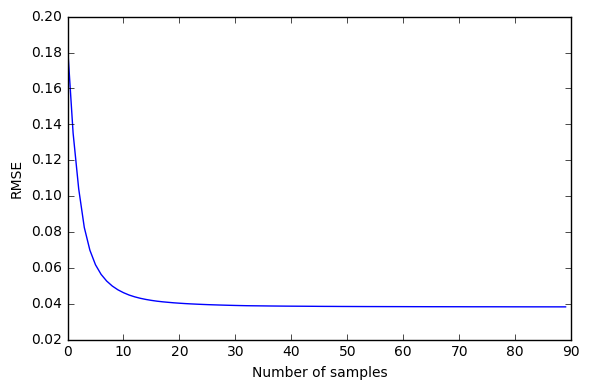

2017-03-16 01:21:49 root:INFO Starting dt=0.1 data 3 run 4...
2017-03-16 01:26:47 hmc.constrained:INFO Quasi-Newton iteration did not converge within max_iters.
Last max error: 0.117379310879
Falling back to scipy.optimize.root(hybrj).
2017-03-16 01:26:47 hmc.base:INFO Error occured when simulating dynamic. Rejecting.
Solver (scipy.optimize.root(hybrj)) did not converge.
Maximum number of iterations: 100
Maximum error for convergence: 1e-08
Last maximum error: 5.72313760383e-07
2017-03-16 01:29:14 hmc.constrained:INFO Quasi-Newton iteration did not converge within max_iters.
Last max error: 4.60169969367e-05
Falling back to scipy.optimize.root(hybrj).
2017-03-16 01:29:15 hmc.base:INFO Error occured when simulating dynamic. Rejecting.
Solver (scipy.optimize.root(hybrj)) did not converge.
Maximum number of iterations: 100
Maximum error for convergence: 1e-08
Last maximum error: 6.82294267129e-06
2017-03-16 01:29:52 hmc.constrained:INFO Quasi-Newton iteration diverged.
2017-03-16 01:29:52

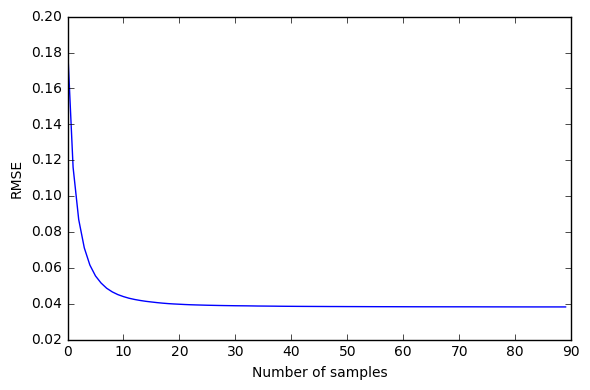

2017-03-16 01:31:21 root:INFO Starting dt=0.1 data 3 run 5...
2017-03-16 01:38:45 hmc.constrained:INFO Quasi-Newton iteration did not converge within max_iters.
Last max error: 1.84599737718e-08
Falling back to scipy.optimize.root(hybrj).
2017-03-16 01:38:45 hmc.constrained:INFO Quasi-Newton iteration diverged.
2017-03-16 01:38:45 hmc.constrained:INFO Quasi-Newton iteration did not converge within max_iters.
Last max error: nan
Falling back to scipy.optimize.root(hybrj).
2017-03-16 01:38:45 hmc.base:INFO Error occured when simulating dynamic. Rejecting.
Solver (scipy.optimize.root(hybrj)) did not converge.
Maximum number of iterations: 100
Maximum error for convergence: 1e-08
Last maximum error: 3.06728213473e-06
2017-03-16 01:40:12 hmc.constrained:INFO Quasi-Newton iteration did not converge within max_iters.
Last max error: 1.07293428808e-06
Falling back to scipy.optimize.root(hybrj).
2017-03-16 01:40:13 hmc.constrained:INFO Quasi-Newton iteration diverged.
2017-03-16 01:40:13 hmc.co

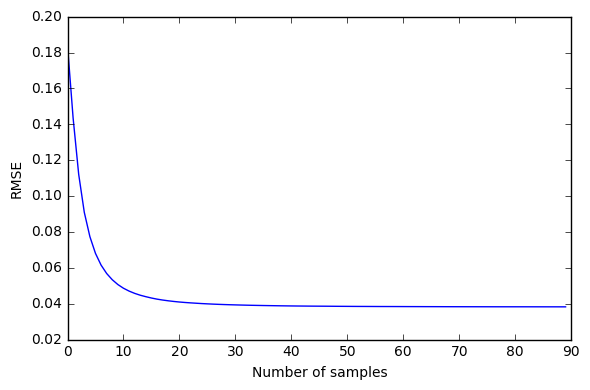

2017-03-16 01:40:45 root:INFO Starting dt=0.1 data 3 run 6...
2017-03-16 01:44:27 hmc.constrained:INFO Quasi-Newton iteration did not converge within max_iters.
Last max error: 0.0259686906034
Falling back to scipy.optimize.root(hybrj).
2017-03-16 01:44:27 hmc.constrained:INFO Quasi-Newton iteration diverged.
2017-03-16 01:44:27 hmc.constrained:INFO Quasi-Newton iteration did not converge within max_iters.
Last max error: nan
Falling back to scipy.optimize.root(hybrj).
2017-03-16 01:44:27 hmc.base:INFO Error occured when simulating dynamic. Rejecting.
Solver (scipy.optimize.root(hybrj)) did not converge.
Maximum number of iterations: 100
Maximum error for convergence: 1e-08
Last maximum error: 2.18198267647e-05
2017-03-16 01:50:22 root:INFO ...completed, accepted: 0.966666666667, run time: 577.6s


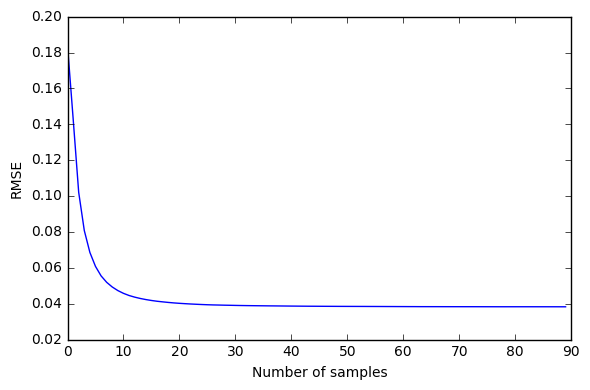

2017-03-16 01:50:23 root:INFO Starting dt=0.1 data 3 run 7...
2017-03-16 01:55:07 hmc.constrained:INFO Quasi-Newton iteration diverged.
2017-03-16 01:55:07 hmc.constrained:INFO Quasi-Newton iteration did not converge within max_iters.
Last max error: nan
Falling back to scipy.optimize.root(hybrj).
2017-03-16 01:55:07 hmc.base:INFO Error occured when simulating dynamic. Rejecting.
Solver (scipy.optimize.root(hybrj)) did not converge.
Maximum number of iterations: 100
Maximum error for convergence: 1e-08
Last maximum error: 0.00106663629627
2017-03-16 01:59:18 hmc.constrained:INFO Quasi-Newton iteration diverged.
2017-03-16 01:59:18 hmc.constrained:INFO Quasi-Newton iteration did not converge within max_iters.
Last max error: nan
Falling back to scipy.optimize.root(hybrj).
2017-03-16 01:59:18 hmc.base:INFO Error occured when simulating dynamic. Rejecting.
Solver (scipy.optimize.root(hybrj)) did not converge.
Maximum number of iterations: 100
Maximum error for convergence: 1e-08
Last maxi

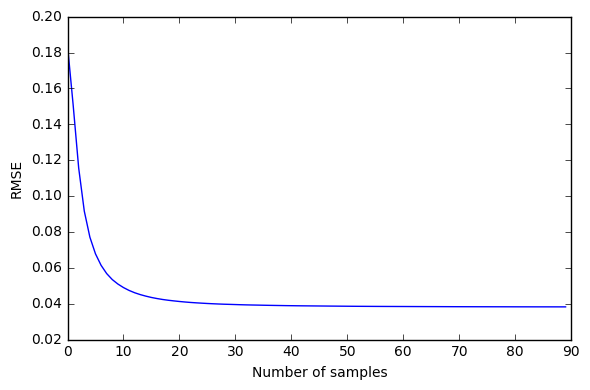

2017-03-16 01:59:37 root:INFO Starting dt=0.1 data 3 run 8...
2017-03-16 02:08:54 root:INFO ...completed, accepted: 0.955555555556, run time: 557.4s


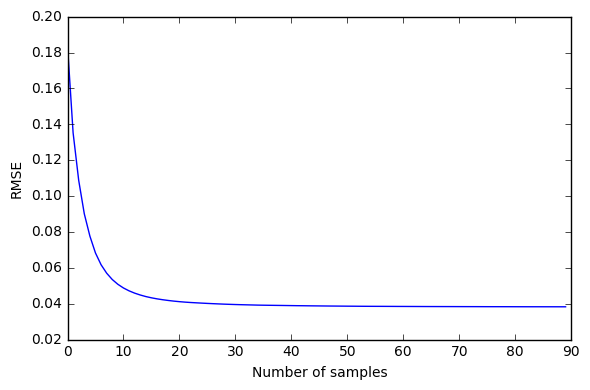

2017-03-16 02:08:54 root:INFO Starting dt=0.1 data 3 run 9...
2017-03-16 02:18:17 root:INFO ...completed, accepted: 0.966666666667, run time: 562.9s


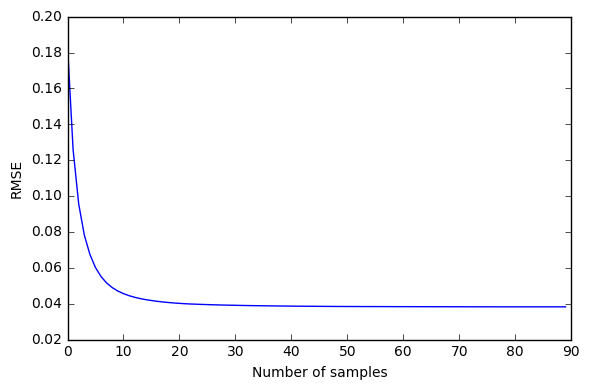

2017-03-16 02:18:17 root:INFO Starting dt=0.1 data 3 run 10...
2017-03-16 02:21:07 hmc.constrained:INFO Quasi-Newton iteration did not converge within max_iters.
Last max error: 49.1648506853
Falling back to scipy.optimize.root(hybrj).
2017-03-16 02:21:07 hmc.base:INFO Error occured when simulating dynamic. Rejecting.
Solver (scipy.optimize.root(hybrj)) did not converge.
Maximum number of iterations: 100
Maximum error for convergence: 1e-08
Last maximum error: 6.28482261988e-06
2017-03-16 02:25:24 hmc.constrained:INFO Quasi-Newton iteration diverged.
2017-03-16 02:25:24 hmc.constrained:INFO Quasi-Newton iteration did not converge within max_iters.
Last max error: nan
Falling back to scipy.optimize.root(hybrj).
2017-03-16 02:25:24 hmc.base:INFO Error occured when simulating dynamic. Rejecting.
Solver (scipy.optimize.root(hybrj)) did not converge.
Maximum number of iterations: 100
Maximum error for convergence: 1e-08
Last maximum error: 1.9317421116e-06
2017-03-16 02:27:28 root:INFO ...c

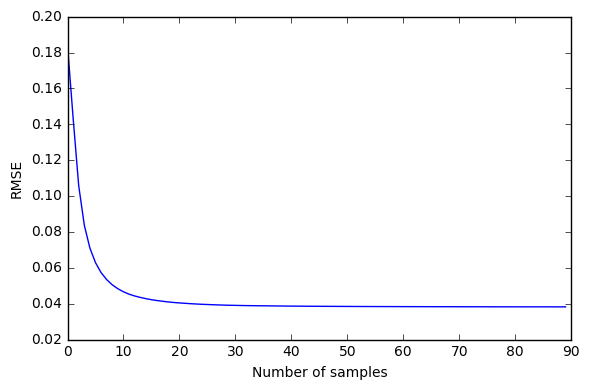

In [17]:
for dt in [1e-1]:
    for d, y, y_3d in zip(range(n_data), y_data, y_data_3d):
        for r in range(n_run):
            try:
                model.y_obs = y
                u_init = np.zeros(n_in_dim)
                y_init = model.generator_func(u_init)
                u_init[-n_noise:] = (y - y_init) / consts['output_noise_std']
                assert np.allclose(model.constr_func(u_init), 0)
                logger.info('Starting dt={0} data {1} run {2}...'.format(dt, d+1, r+1))
                start_time = timer()
                u_samples, p_samples, accept = constr_sampler.get_samples(
                    pos=u_init.copy(), dt=dt, n_step_per_sample=n_step_per_sample, n_sample=n_sample
                )
                run_time = timer() - start_time
                logger.info('...completed, accepted: {0}, run time: {1:.1f}s'.format(accept, run_time))
                y_3d_samples = generator_3d(u_samples)
                fig, ax, dists = vis.plot_posterior_mean_rmse(
                    y_3d.flatten(), y_3d_samples.reshape(n_sample, -1), fig_size=(6, 4))
                fig.tight_layout()
                plt.show()
                chmc_times[r] = run_time
                chmc_dists[r] = dists
                np.savez(os.path.join(exp_dir, 'chmc_dt_{0:.0e}_data_{1}_run_{2}.npz'.format(dt, d+1, r+1)),
                    u_samples=u_samples, accept=accept, run_time=run_time, dt=dt, 
                    y_3d_samples=y_3d_samples, dists=dists)
            except Exception as e:
                logger.exception('Error encountered dt={0} data {1} run {2}:'.format(dt, d+1, r+1))

## HMC in hierarchical model (generator input)

In [18]:
u = tt.vector('u')
y_obs = th.shared(y_data[0])
y_model = tt.squeeze(pose.binocular_2d_proj_generator(u, consts))
energy_hier_1 = 0.5 * ((y_model - y_obs)**2 / consts['output_noise_std']**2).sum() + 0.5 * u.dot(u)

In [19]:
energy_hier_func_1 = th.function([u], energy_hier_1)
energy_hier_grad_1 = th.function([u], tt.grad(energy_hier_1, u))

In [20]:
u_sampler = hmc.unconstrained.IsotropicHmcSampler(
    lambda u, cache={}: energy_hier_func_1(u), 
    lambda u, cache={}: energy_hier_grad_1(u),
    rng)
n_step_per_sample = (100, 150)
n_sample = 2500
u_init = np.zeros(n_in_dim - n_noise)
rng.seed(consts['seed'])
n_run = 10
hmc_1_times = np.empty(n_run) * np.nan
hmc_1_dists = np.empty((n_run, n_sample)) * np.nan

2017-03-16 02:28:08 root:INFO Starting dt=0.0002 data 1 run 1...
2017-03-16 02:48:55 root:INFO ...completed, accepted: 0.9864, run time: 1247.0s


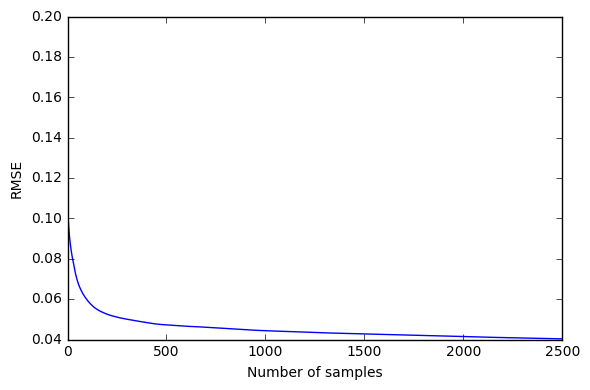

2017-03-16 02:48:56 root:INFO Starting dt=0.0002 data 1 run 2...
2017-03-16 03:09:53 root:INFO ...completed, accepted: 0.9856, run time: 1257.1s


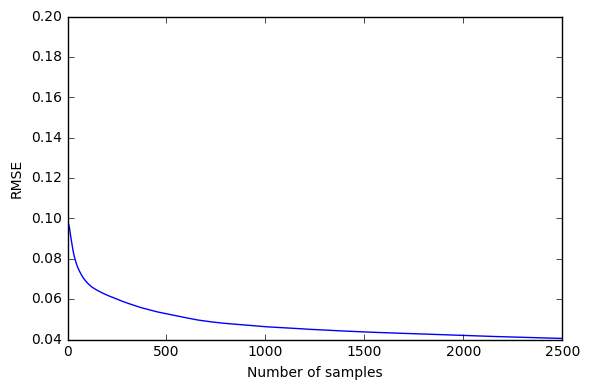

2017-03-16 03:09:53 root:INFO Starting dt=0.0002 data 1 run 3...
2017-03-16 03:30:49 root:INFO ...completed, accepted: 0.988, run time: 1255.5s


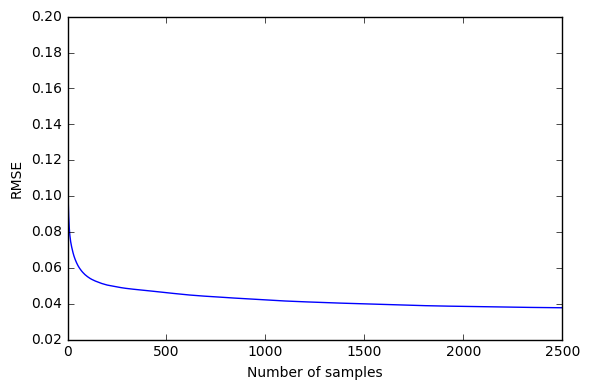

2017-03-16 03:30:49 root:INFO Starting dt=0.0002 data 1 run 4...
2017-03-16 03:51:54 root:INFO ...completed, accepted: 0.97, run time: 1265.0s


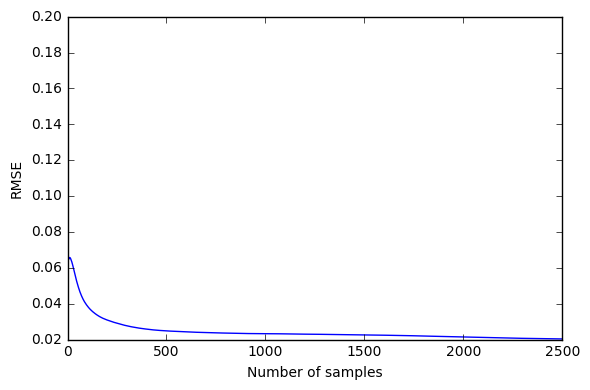

2017-03-16 03:51:55 root:INFO Starting dt=0.0002 data 1 run 5...
2017-03-16 04:12:57 root:INFO ...completed, accepted: 0.9616, run time: 1262.5s


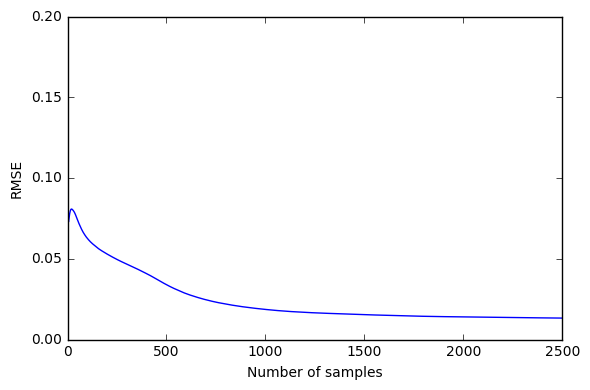

2017-03-16 04:12:58 root:INFO Starting dt=0.0002 data 1 run 6...
2017-03-16 04:34:25 root:INFO ...completed, accepted: 0.9828, run time: 1287.6s


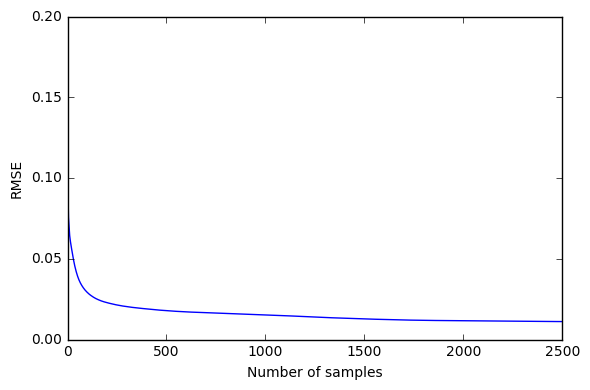

2017-03-16 04:34:26 root:INFO Starting dt=0.0002 data 1 run 7...
2017-03-16 04:55:22 root:INFO ...completed, accepted: 0.9864, run time: 1256.0s


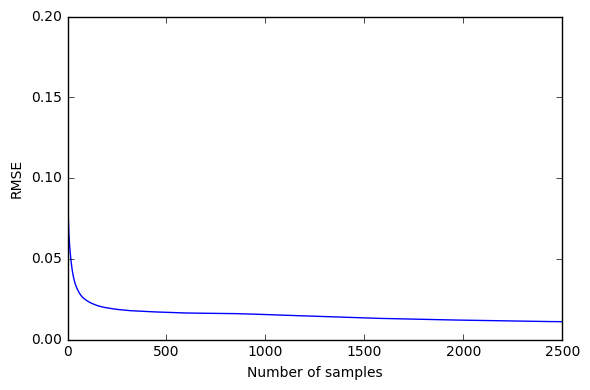

2017-03-16 04:55:22 root:INFO Starting dt=0.0002 data 1 run 8...
2017-03-16 05:16:25 root:INFO ...completed, accepted: 0.988, run time: 1262.4s


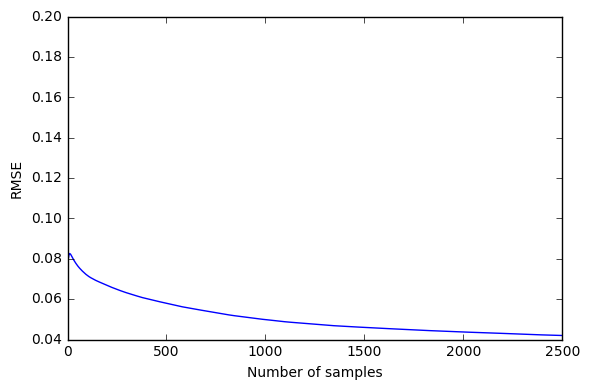

2017-03-16 05:16:25 root:INFO Starting dt=0.0002 data 1 run 9...
2017-03-16 05:36:50 root:INFO ...completed, accepted: 0.9812, run time: 1224.7s


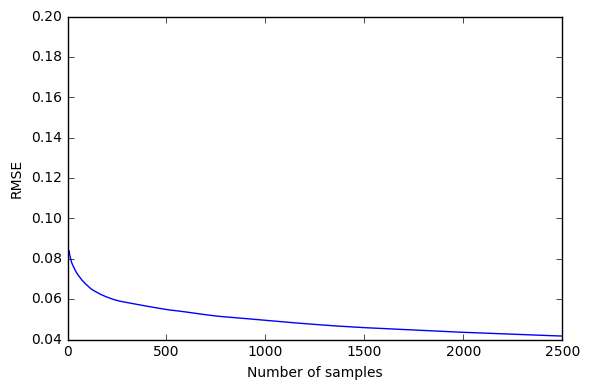

2017-03-16 05:36:50 root:INFO Starting dt=0.0002 data 1 run 10...
2017-03-16 05:57:41 root:INFO ...completed, accepted: 0.988, run time: 1250.9s


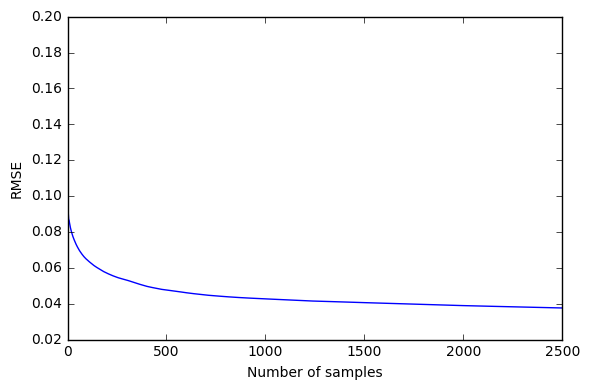

2017-03-16 05:57:42 root:INFO Starting dt=0.0002 data 2 run 1...
2017-03-16 06:18:33 root:INFO ...completed, accepted: 0.9364, run time: 1251.9s


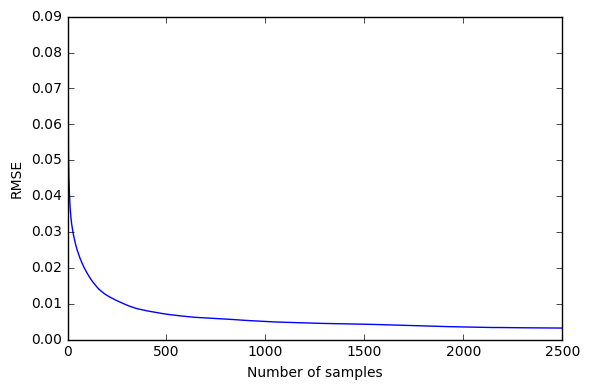

2017-03-16 06:18:34 root:INFO Starting dt=0.0002 data 2 run 2...
2017-03-16 06:39:31 root:INFO ...completed, accepted: 0.946, run time: 1257.4s


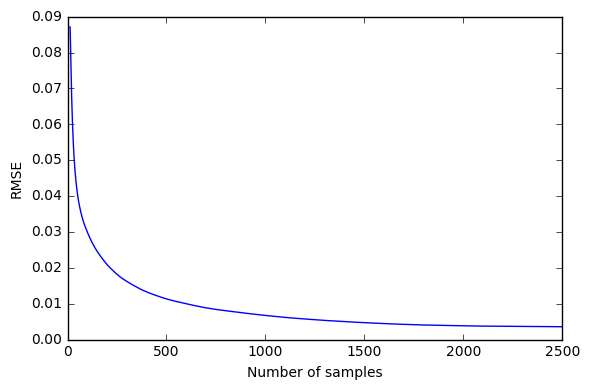

2017-03-16 06:39:32 root:INFO Starting dt=0.0002 data 2 run 3...
2017-03-16 07:00:13 root:INFO ...completed, accepted: 0.9396, run time: 1241.2s


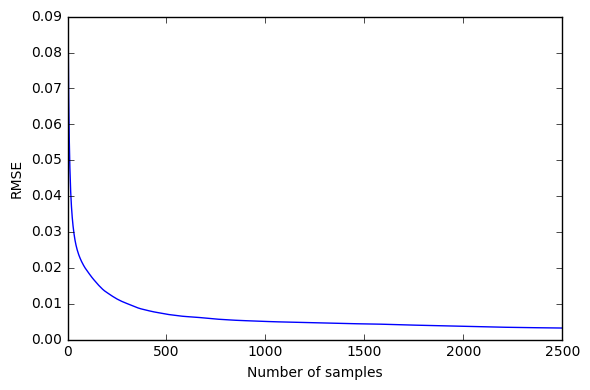

2017-03-16 07:00:13 root:INFO Starting dt=0.0002 data 2 run 4...
2017-03-16 07:21:02 root:INFO ...completed, accepted: 0.9336, run time: 1249.0s


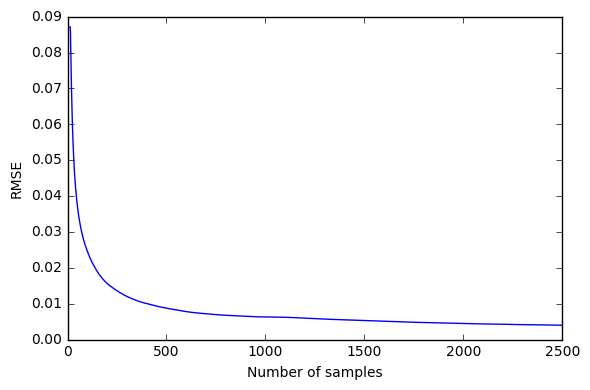

2017-03-16 07:21:03 root:INFO Starting dt=0.0002 data 2 run 5...
2017-03-16 07:41:59 root:INFO ...completed, accepted: 0.9344, run time: 1256.1s


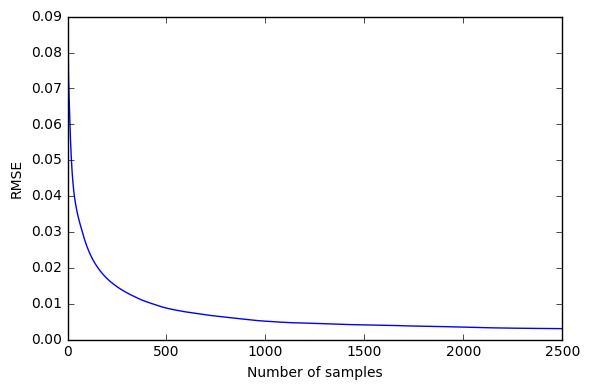

2017-03-16 07:41:59 root:INFO Starting dt=0.0002 data 2 run 6...
2017-03-16 08:03:04 root:INFO ...completed, accepted: 0.9088, run time: 1264.5s


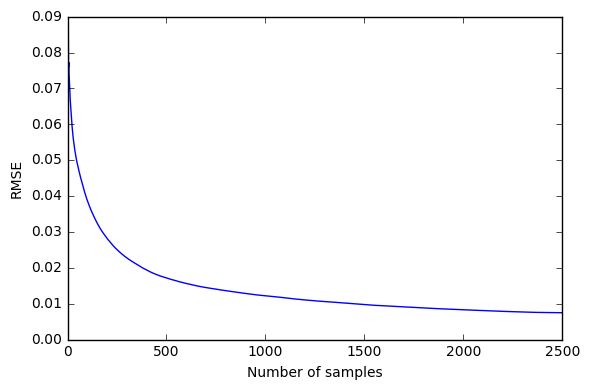

2017-03-16 08:03:05 root:INFO Starting dt=0.0002 data 2 run 7...
2017-03-16 08:24:07 root:INFO ...completed, accepted: 0.9332, run time: 1262.8s


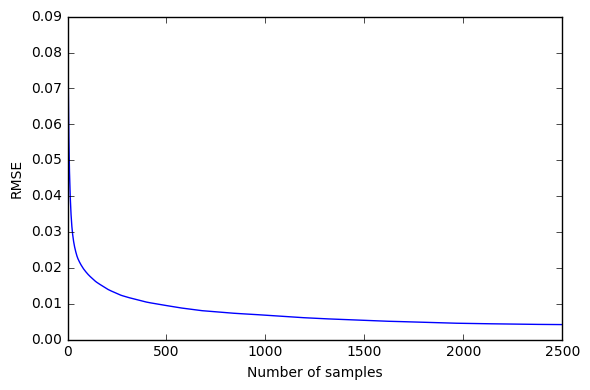

2017-03-16 08:24:08 root:INFO Starting dt=0.0002 data 2 run 8...
2017-03-16 08:45:00 root:INFO ...completed, accepted: 0.9372, run time: 1252.5s


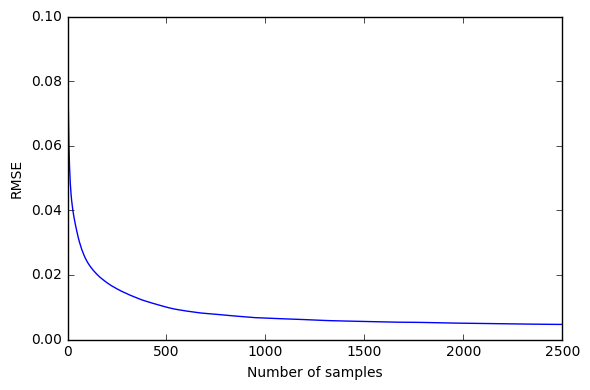

2017-03-16 08:45:01 root:INFO Starting dt=0.0002 data 2 run 9...
2017-03-16 09:05:41 root:INFO ...completed, accepted: 0.9412, run time: 1240.6s


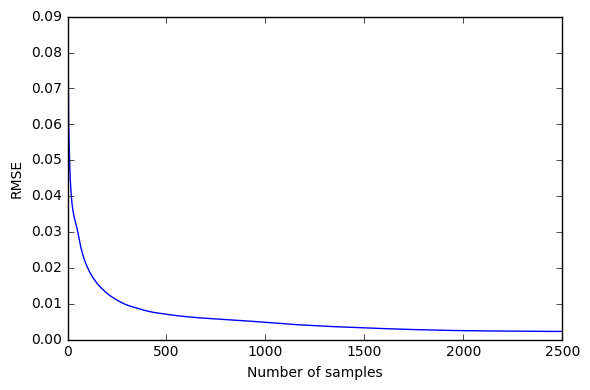

2017-03-16 09:05:42 root:INFO Starting dt=0.0002 data 2 run 10...
2017-03-16 09:26:34 root:INFO ...completed, accepted: 0.9424, run time: 1252.2s


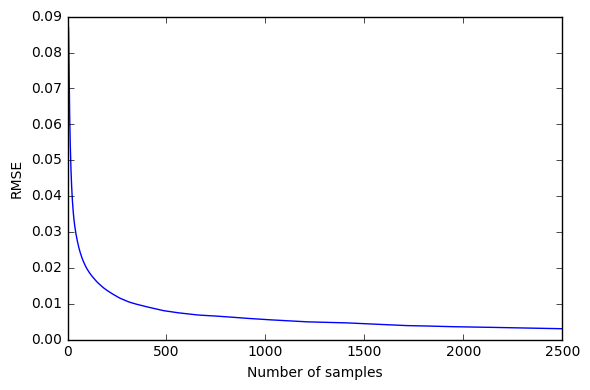

2017-03-16 09:26:34 root:INFO Starting dt=0.0002 data 3 run 1...
2017-03-16 09:47:33 root:INFO ...completed, accepted: 0.9516, run time: 1258.4s


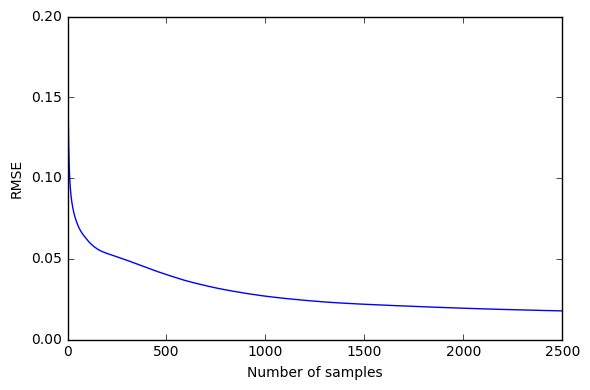

2017-03-16 09:47:33 root:INFO Starting dt=0.0002 data 3 run 2...
2017-03-16 10:08:07 root:INFO ...completed, accepted: 0.8732, run time: 1233.2s


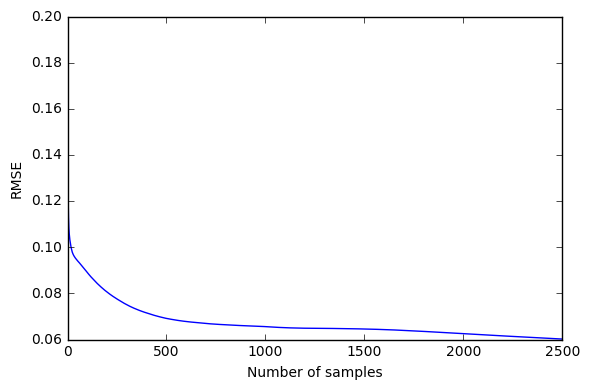

2017-03-16 10:08:07 root:INFO Starting dt=0.0002 data 3 run 3...
2017-03-16 10:29:16 root:INFO ...completed, accepted: 0.9756, run time: 1269.4s


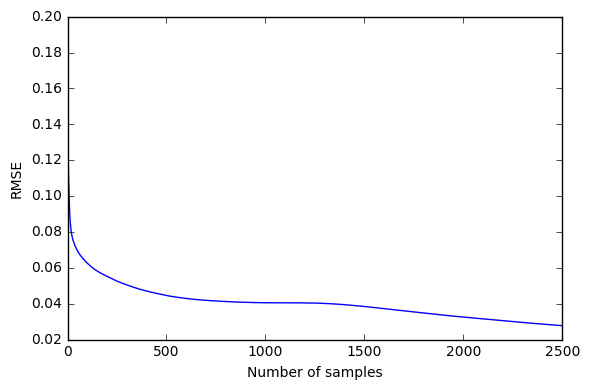

2017-03-16 10:29:17 root:INFO Starting dt=0.0002 data 3 run 4...
2017-03-16 10:50:30 root:INFO ...completed, accepted: 0.9832, run time: 1273.3s


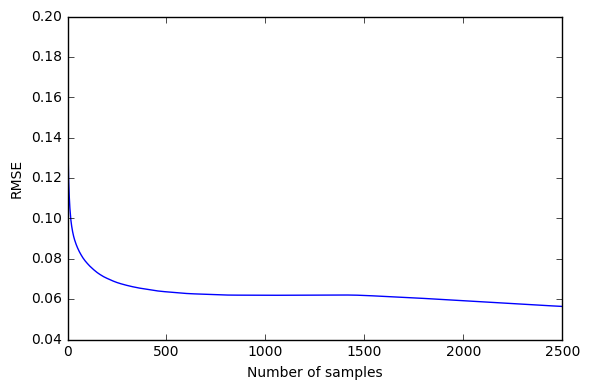

2017-03-16 10:50:31 root:INFO Starting dt=0.0002 data 3 run 5...
2017-03-16 11:11:26 root:INFO ...completed, accepted: 0.084, run time: 1255.5s


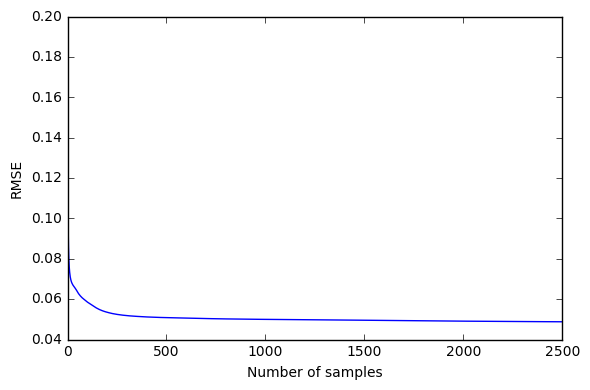

2017-03-16 11:11:27 root:INFO Starting dt=0.0002 data 3 run 6...
2017-03-16 11:31:55 root:INFO ...completed, accepted: 0.9688, run time: 1228.7s


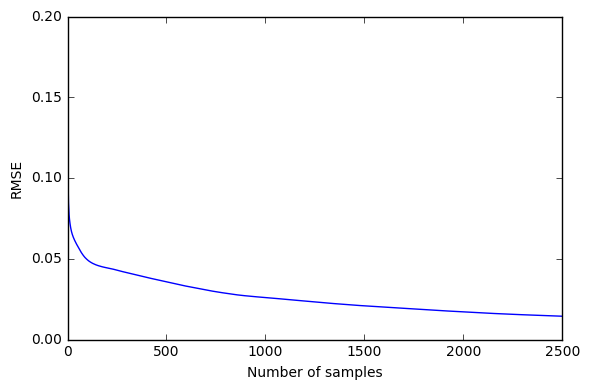

2017-03-16 11:31:56 root:INFO Starting dt=0.0002 data 3 run 7...
2017-03-16 11:53:01 root:INFO ...completed, accepted: 0.9828, run time: 1265.2s


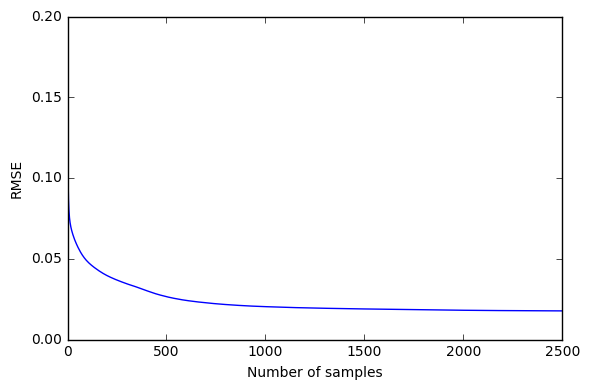

2017-03-16 11:53:01 root:INFO Starting dt=0.0002 data 3 run 8...
2017-03-16 12:13:46 root:INFO ...completed, accepted: 0.208, run time: 1245.0s


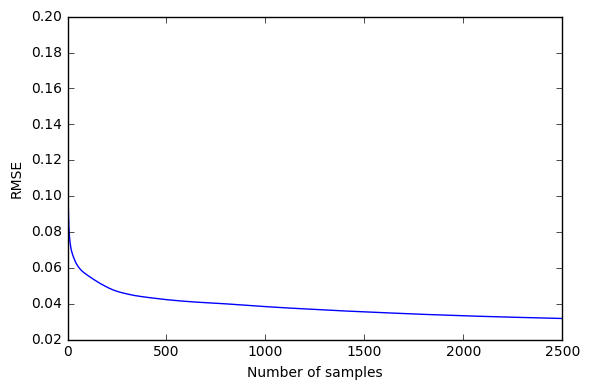

2017-03-16 12:13:47 root:INFO Starting dt=0.0002 data 3 run 9...
2017-03-16 12:34:19 root:INFO ...completed, accepted: 0.1448, run time: 1231.9s


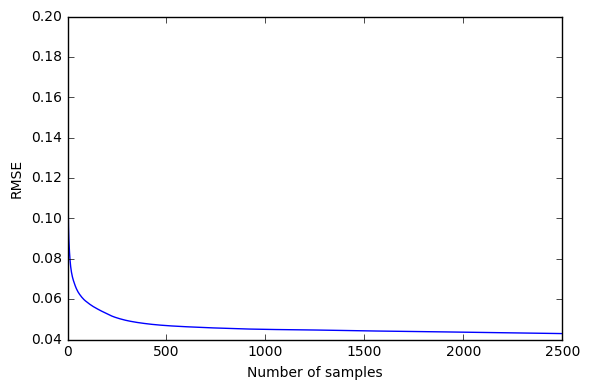

2017-03-16 12:34:19 root:INFO Starting dt=0.0002 data 3 run 10...
2017-03-16 12:55:28 root:INFO ...completed, accepted: 0.048, run time: 1269.0s


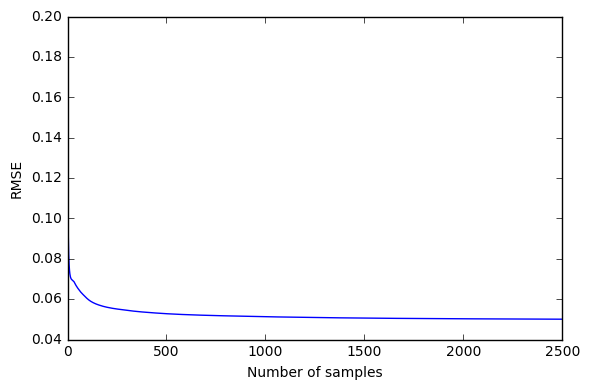

In [21]:
for dt in [2e-4]:
    for d, y, y_3d in zip(range(n_data), y_data, y_data_3d):
        for r in range(n_run):
            try:
                y_obs.set_value(y)
                logger.info('Starting dt={0} data {1} run {2}...'.format(dt, d+1, r+1))
                start_time = timer()
                u_samples, mom_samples, accept = u_sampler.get_samples(
                    pos=u_init * 1., dt=dt, 
                    n_step_per_sample=n_step_per_sample, n_sample=n_sample)
                run_time = timer() - start_time
                logger.info('...completed, accepted: {0}, run time: {1:.1f}s'.format(accept, run_time))
                y_3d_samples = generator_3d(u_samples)
                fig, ax, dists = vis.plot_posterior_mean_rmse(
                    y_3d.flatten(), y_3d_samples.reshape(n_sample, -1), fig_size=(6, 4))
                fig.tight_layout()
                plt.show()
                hmc_1_times[r] = run_time
                hmc_1_dists[r] = dists
                np.savez(os.path.join(exp_dir, 
                                      'hmc_hier_1_dt_{0:.0e}_data_{1}_run_{2}.npz'
                                      .format(dt, d+1, r+1)),
                         u_samples=u_samples, accept=accept, run_time=run_time, dt=dt, 
                         y_3d_samples=y_3d_samples, dists=dists)
            except Exception as e:
                logger.exception('Error encountered dt={0} data {1} run {2}:'.format(dt, d+1, r+1))

## HMC in hierarchical model (state input)

In [22]:
state = tt.vector('state')
y_obs = th.shared(y_data[0])
energy_hier_2 = pose.energy_func_hier_binocular(state, y_obs, consts)

In [23]:
energy_hier_func_2 = th.function([state], energy_hier_2)
energy_hier_grad_2 = th.function([state], tt.grad(energy_hier_2, state))

In [24]:
states = tt.matrix('states')
y_3d_hier = pose.joint_3d_pos_generator_hier(states, consts)
generator_3d_hier = th.function([states], y_3d_hier)

In [25]:
h = tt.vector('h')
joint_angles_cos_sin_mean, _ = pose.joint_angles_cos_sin_vae_decoder(
    h[None, :], consts['joint_angles_vae_decoder_layers'], consts['n_joint_angle'])
joint_angles_cos_sin_mean_func = th.function([h], tt.squeeze(joint_angles_cos_sin_mean))

In [26]:
state_init = np.r_[
    consts['log_lengths_mean'].eval(),
    np.zeros(shape=consts['n_joint_angle_latent']),
    joint_angles_cos_sin_mean_func(np.zeros(consts['n_joint_angle_latent'])),
    consts['cam_pos_x_mean'], consts['cam_pos_y_mean'],
    consts['log_cam_pos_z_mean']
]

In [27]:
u_state_sampler = hmc.unconstrained.IsotropicHmcSampler(
    lambda u, cache={}: energy_hier_func_2(u), 
    lambda u, cache={}: energy_hier_grad_2(u),
    rng)
n_step_per_sample = (100, 150)
n_sample = 2500
rng.seed(consts['seed'])
n_run = 10
hmc_2_times = np.empty(n_run) * np.nan
hmc_2_dists = np.empty((n_run, n_sample)) * np.nan

2017-03-16 12:55:52 root:INFO Starting dt=0.0001 data 1 run 1...
2017-03-16 13:16:01 root:INFO ...completed, accepted: 0.9612, run time: 1209.3s


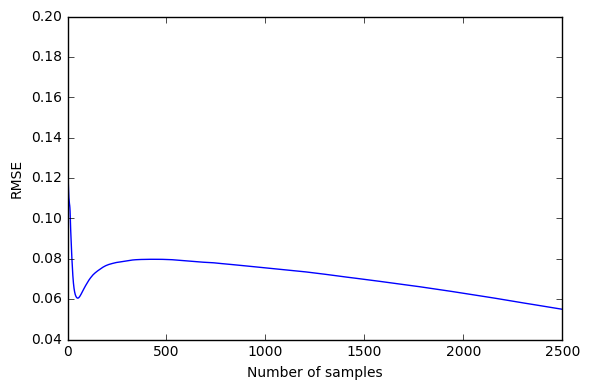

2017-03-16 13:16:02 root:INFO Starting dt=0.0001 data 1 run 2...
2017-03-16 13:36:17 root:INFO ...completed, accepted: 0.9664, run time: 1215.2s


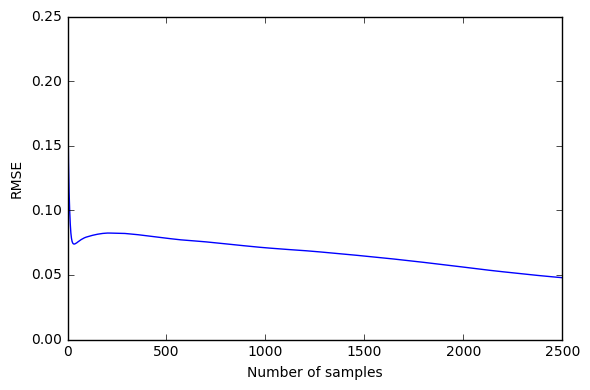

2017-03-16 13:36:17 root:INFO Starting dt=0.0001 data 1 run 3...
2017-03-16 13:56:25 root:INFO ...completed, accepted: 0.9656, run time: 1207.5s


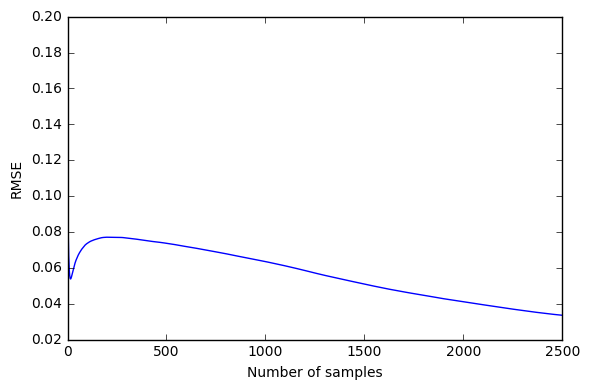

2017-03-16 13:56:25 root:INFO Starting dt=0.0001 data 1 run 4...
2017-03-16 14:16:43 root:INFO ...completed, accepted: 0.9684, run time: 1218.5s


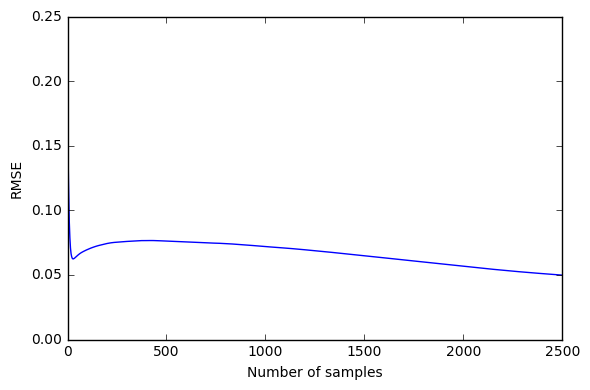

2017-03-16 14:16:44 root:INFO Starting dt=0.0001 data 1 run 5...
2017-03-16 14:36:54 root:INFO ...completed, accepted: 0.9652, run time: 1210.0s


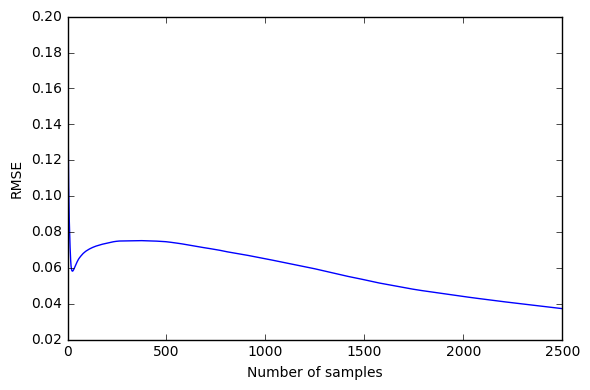

2017-03-16 14:36:54 root:INFO Starting dt=0.0001 data 1 run 6...
2017-03-16 14:56:58 root:INFO ...completed, accepted: 0.9636, run time: 1204.3s


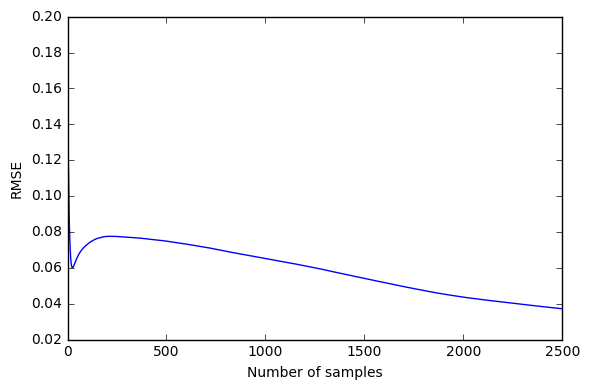

2017-03-16 14:56:59 root:INFO Starting dt=0.0001 data 1 run 7...
2017-03-16 15:17:52 root:INFO ...completed, accepted: 0.9552, run time: 1252.6s


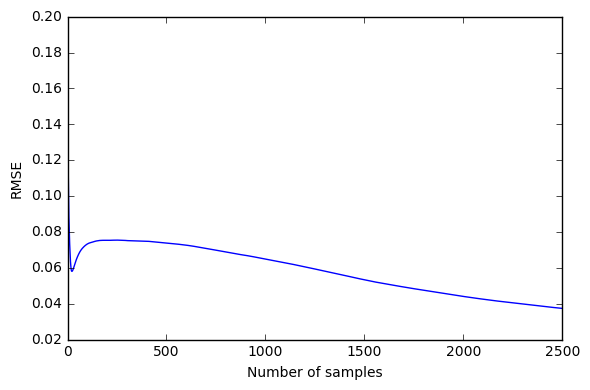

2017-03-16 15:17:52 root:INFO Starting dt=0.0001 data 1 run 8...
2017-03-16 15:38:11 root:INFO ...completed, accepted: 0.97, run time: 1219.2s


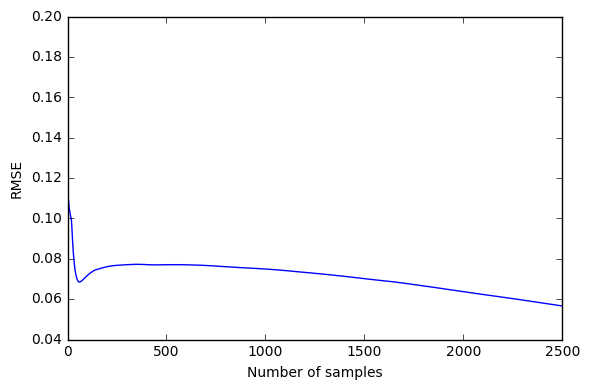

2017-03-16 15:38:12 root:INFO Starting dt=0.0001 data 1 run 9...
2017-03-16 15:58:28 root:INFO ...completed, accepted: 0.9632, run time: 1216.1s


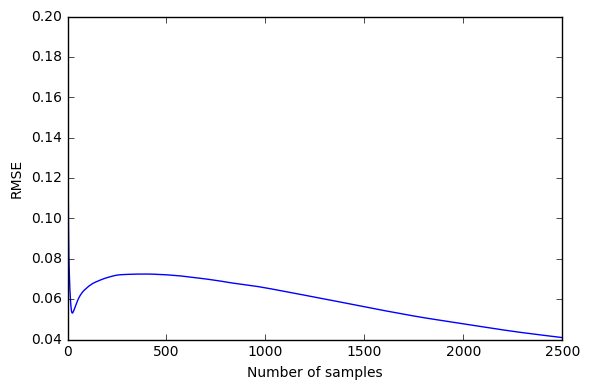

2017-03-16 15:58:28 root:INFO Starting dt=0.0001 data 1 run 10...
2017-03-16 16:18:35 root:INFO ...completed, accepted: 0.9656, run time: 1206.7s


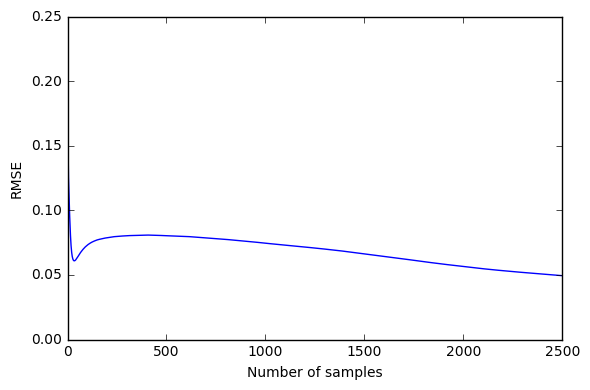

2017-03-16 16:18:35 root:INFO Starting dt=0.0001 data 2 run 1...
2017-03-16 16:38:55 root:INFO ...completed, accepted: 0.8604, run time: 1219.5s


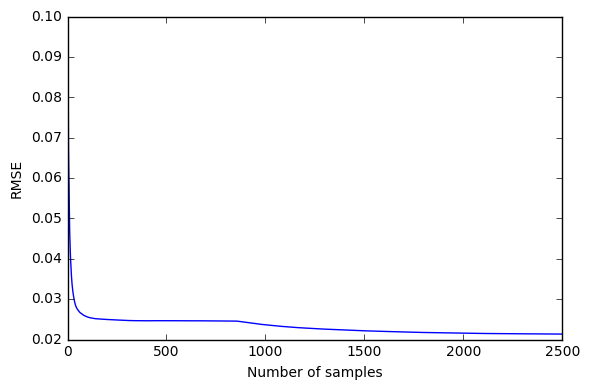

2017-03-16 16:38:55 root:INFO Starting dt=0.0001 data 2 run 2...
2017-03-16 16:59:10 root:INFO ...completed, accepted: 0.8544, run time: 1215.2s


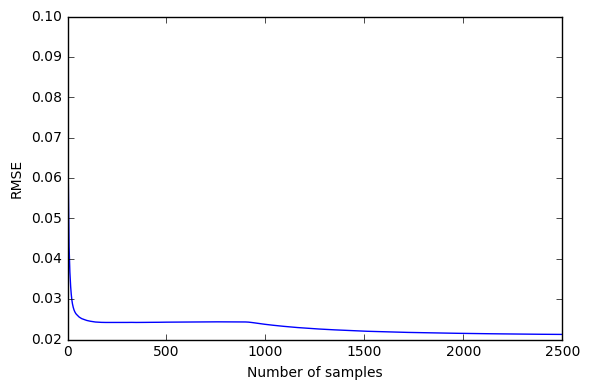

2017-03-16 16:59:11 root:INFO Starting dt=0.0001 data 2 run 3...
2017-03-16 17:19:21 root:INFO ...completed, accepted: 0.8584, run time: 1210.3s


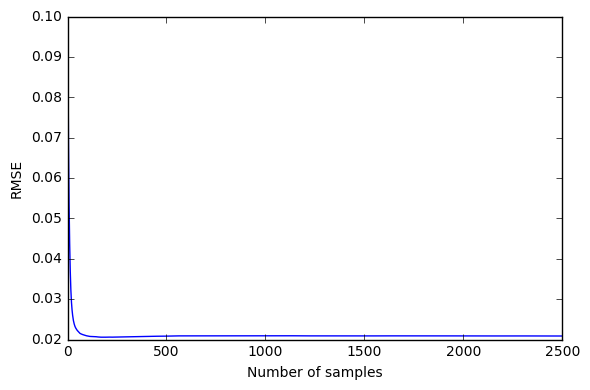

2017-03-16 17:19:21 root:INFO Starting dt=0.0001 data 2 run 4...
2017-03-16 17:39:38 root:INFO ...completed, accepted: 0.8544, run time: 1216.4s


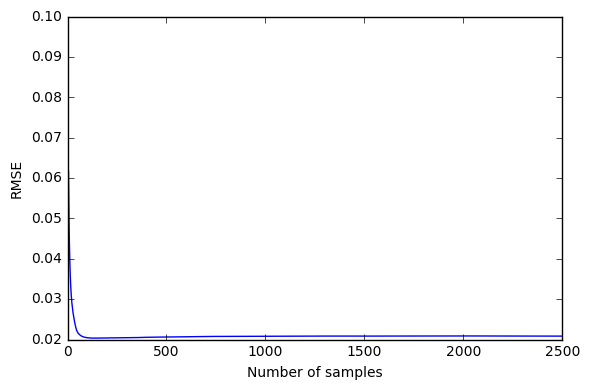

2017-03-16 17:39:38 root:INFO Starting dt=0.0001 data 2 run 5...
2017-03-16 17:59:50 root:INFO ...completed, accepted: 0.864, run time: 1211.4s


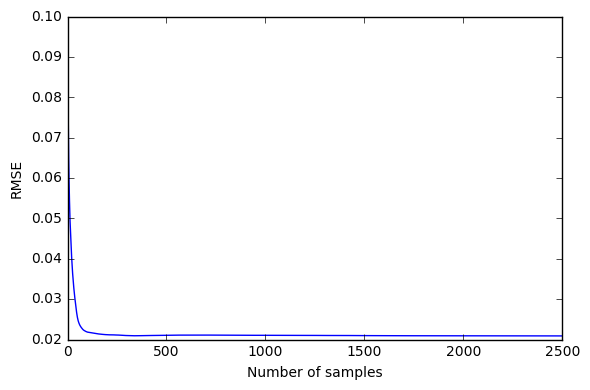

2017-03-16 17:59:50 root:INFO Starting dt=0.0001 data 2 run 6...
2017-03-16 18:19:48 root:INFO ...completed, accepted: 0.8644, run time: 1198.4s


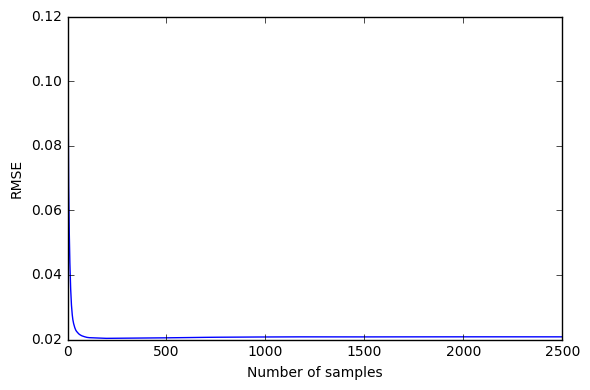

2017-03-16 18:19:49 root:INFO Starting dt=0.0001 data 2 run 7...
2017-03-16 18:40:04 root:INFO ...completed, accepted: 0.8588, run time: 1215.4s


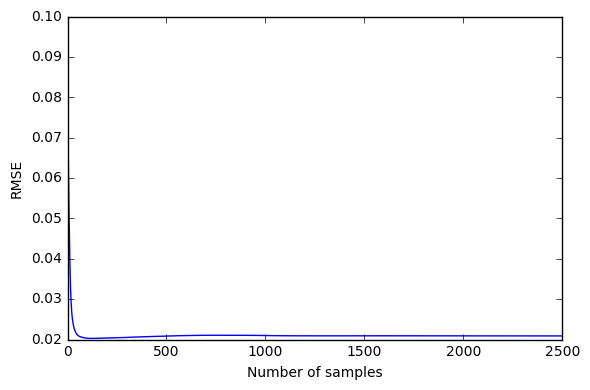

2017-03-16 18:40:05 root:INFO Starting dt=0.0001 data 2 run 8...
2017-03-16 19:00:13 root:INFO ...completed, accepted: 0.8496, run time: 1208.6s


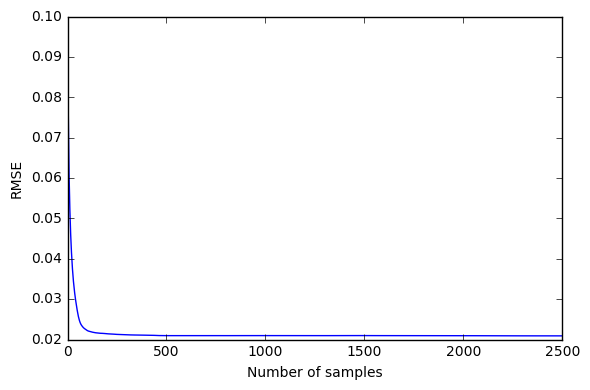

2017-03-16 19:00:14 root:INFO Starting dt=0.0001 data 2 run 9...
2017-03-16 19:20:42 root:INFO ...completed, accepted: 0.8644, run time: 1228.9s


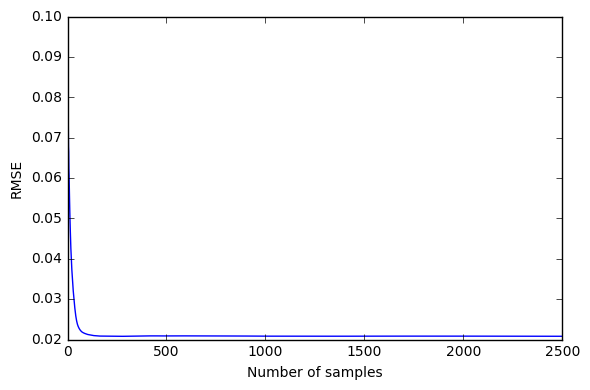

2017-03-16 19:20:43 root:INFO Starting dt=0.0001 data 2 run 10...
2017-03-16 19:41:23 root:INFO ...completed, accepted: 0.8624, run time: 1240.4s


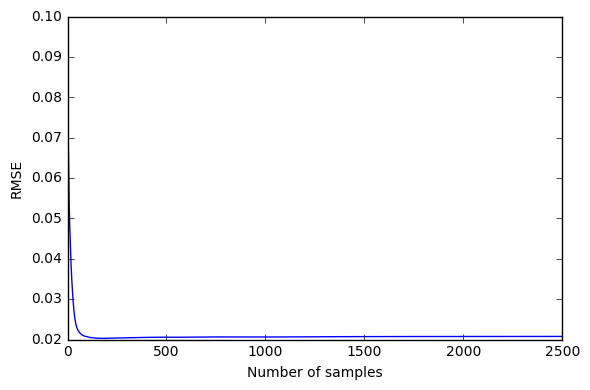

2017-03-16 19:41:23 root:INFO Starting dt=0.0001 data 3 run 1...
2017-03-16 20:01:49 root:INFO ...completed, accepted: 0.9368, run time: 1225.6s


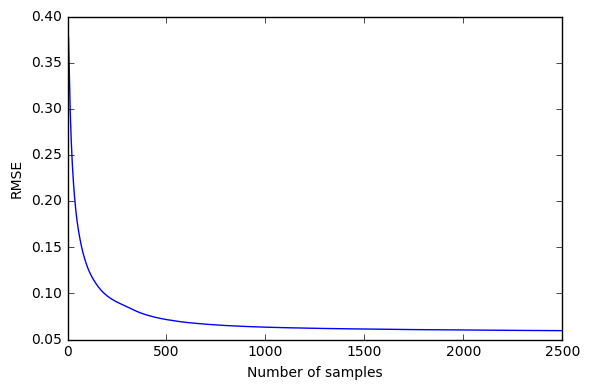

2017-03-16 20:01:49 root:INFO Starting dt=0.0001 data 3 run 2...
2017-03-16 20:21:45 root:INFO ...completed, accepted: 0.8996, run time: 1195.3s


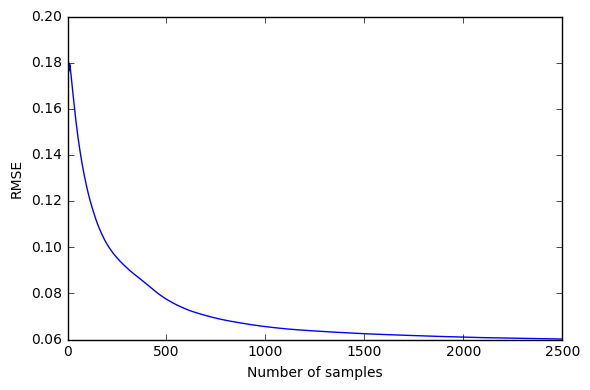

2017-03-16 20:21:45 root:INFO Starting dt=0.0001 data 3 run 3...
2017-03-16 20:42:00 root:INFO ...completed, accepted: 0.884, run time: 1215.0s


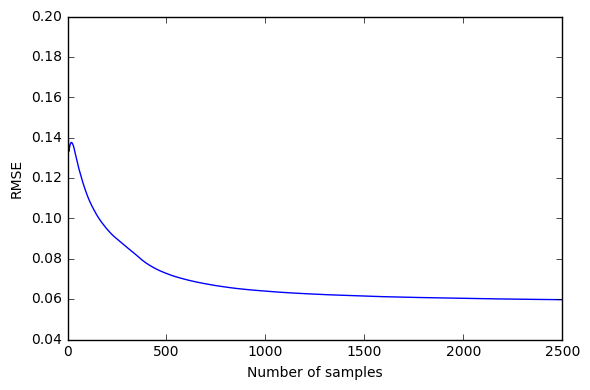

2017-03-16 20:42:01 root:INFO Starting dt=0.0001 data 3 run 4...
2017-03-16 21:02:56 root:INFO ...completed, accepted: 0.9368, run time: 1255.2s


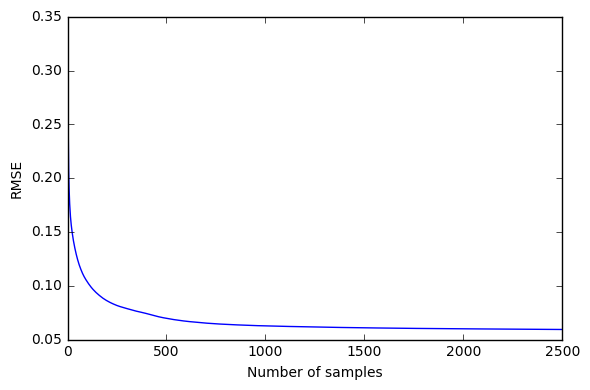

2017-03-16 21:02:56 root:INFO Starting dt=0.0001 data 3 run 5...
2017-03-16 21:23:31 root:INFO ...completed, accepted: 0.932, run time: 1235.0s


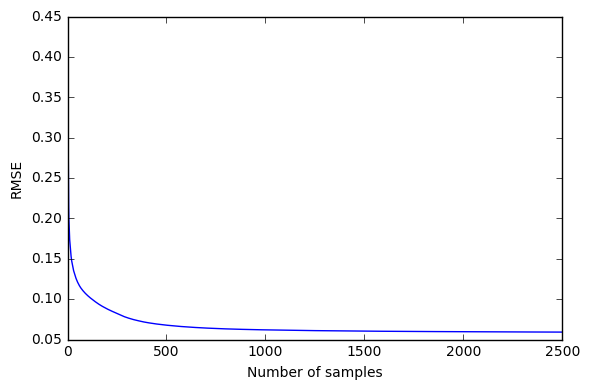

2017-03-16 21:23:32 root:INFO Starting dt=0.0001 data 3 run 6...
2017-03-16 21:44:05 root:INFO ...completed, accepted: 0.944, run time: 1233.1s


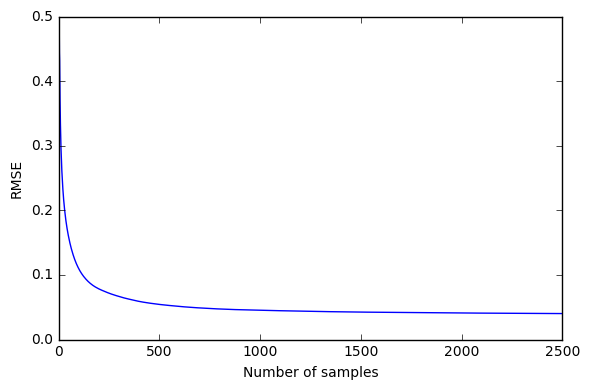

2017-03-16 21:44:05 root:INFO Starting dt=0.0001 data 3 run 7...
2017-03-16 22:05:07 root:INFO ...completed, accepted: 0.924, run time: 1261.7s


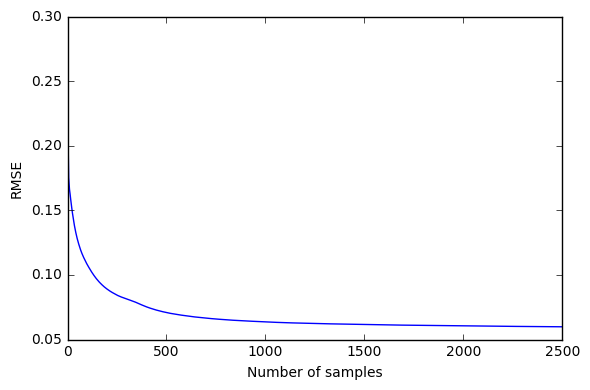

2017-03-16 22:05:07 root:INFO Starting dt=0.0001 data 3 run 8...
2017-03-16 22:25:48 root:INFO ...completed, accepted: 0.9332, run time: 1241.1s


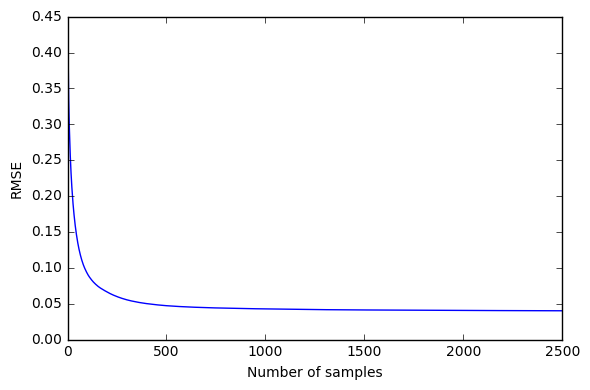

2017-03-16 22:25:49 root:INFO Starting dt=0.0001 data 3 run 9...
2017-03-16 22:46:14 root:INFO ...completed, accepted: 0.9348, run time: 1225.7s


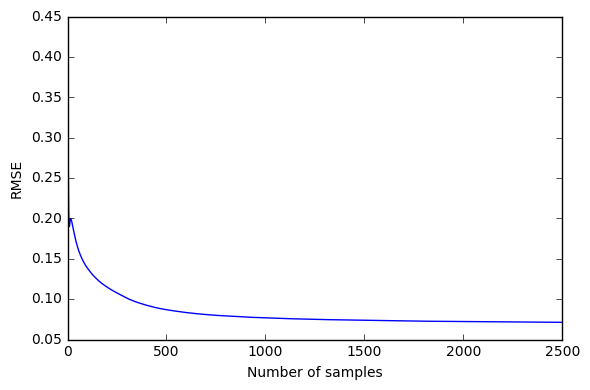

2017-03-16 22:46:15 root:INFO Starting dt=0.0001 data 3 run 10...
2017-03-16 23:06:54 root:INFO ...completed, accepted: 0.8768, run time: 1239.5s


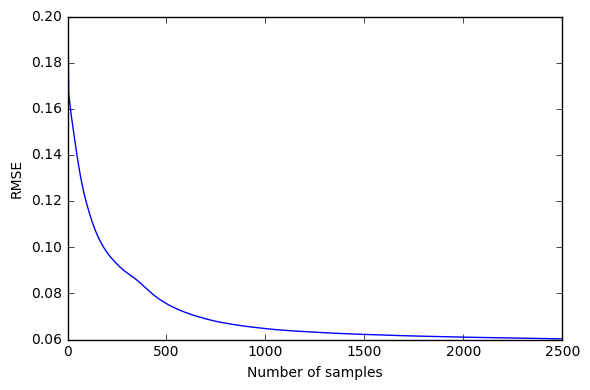

In [28]:
for dt in [1e-4]:
    for d, y, y_3d in zip(range(n_data), y_data, y_data_3d):
        for r in range(n_run):
            try:
                y_obs.set_value(y)
                logger.info('Starting dt={0} data {1} run {2}...'.format(dt, d+1, r+1))
                start_time = timer()
                state_samples, mom_samples, accept = u_state_sampler.get_samples(
                    pos=state_init * 1., dt=dt, n_step_per_sample=n_step_per_sample, n_sample=n_sample)
                run_time = timer() - start_time
                logger.info('...completed, accepted: {0}, run time: {1:.1f}s'.format(accept, run_time))
                y_3d_samples = generator_3d_hier(state_samples).reshape((-1, n_noise))
                fig, ax, dists = vis.plot_posterior_mean_rmse(
                    y_3d.flatten(), y_3d_samples.reshape(n_sample, -1), fig_size=(6, 4))
                fig.tight_layout()
                plt.show()
                hmc_2_times[r] = run_time
                hmc_2_dists[r] = dists
                np.savez(os.path.join(exp_dir, 
                                      'hmc_hier_2_dt_{0:.0e}_data_{1}_run_{2}.npz'
                                      .format(dt, d+1, r+1)),
                         state_samples=state_samples, accept=accept, run_time=run_time, dt=dt,
                         y_3d_samples=y_3d_samples, dists=dists)
            except Exception as e:
                logger.exception('Error encountered dt={0} data {1} run {2}:'.format(dt, d+1, r+1))